In [2]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'
from orographicPrecipitation.precip_extremes_scaling import scaling

#import metpy.calc as mpcalc
#from metpy.plots import SkewT
#from metpy.units import units
import wrf
from netCDF4 import Dataset

In [3]:
xr.set_options(display_style='text') 

# Functions, data

In [4]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [ ]:
drychannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_dry.wrf.100x10.mountain.100km.180d/')

In [ ]:
drychannel2 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_dry2.wrf.100x10.mountain.100km.180d/')

In [5]:
dryhrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/')

In [6]:
hrchannel = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/')

In [7]:
#hgt = drychannel.HGT.isel(south_north=0,Time=-1).persist()
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()
def plotsection(hgt):
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot((50-hgt.west_east)*100,hgt,color='k')
    return ax,ax.twinx()

In [8]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [9]:
def interp_pressure(var):
    """var must be destaggered"""
    plevs= np.arange(125.,990.,20.)[::-1]
    return wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-01-01_00_00_00'),
                         var,"pressure",plevs
                        ).rename({'interp_level':'pressure'}).fillna(0.)

# Low res

## Temperature soundings

In [15]:
sigma = drychannel.ZNU.isel(Time=-1)

Text(0.5, 1.0, 'domain-mean potential temperature')

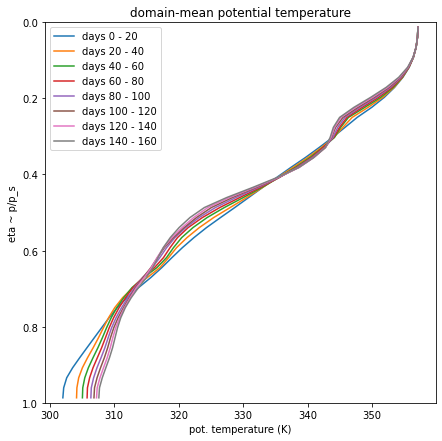

In [44]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

n=20
for i in range(8):
    ax.plot(300+drychannel.T.isel(Time=slice(4*n*i,4*n*(i+1))).mean(['Time','south_north','west_east']),sigma,label='days %i - %i'%(n*i,n*(i+1)))
ax.legend()
ax.set_xlabel('pot. temperature (K)')
ax.set_ylabel('eta ~ p/p_s')
ax.set_ylim(1,0)
ax.set_title('domain-mean potential temperature')


Text(0.5, 1.0, 'domain-mean potential temperature')

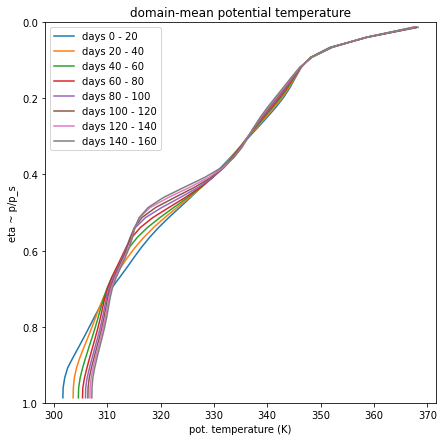

In [16]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

n=20
for i in range(8):
    ax.plot(300+drychannel2.T.isel(Time=slice(4*n*i,4*n*(i+1))).mean(['Time','south_north','west_east']),sigma,label='days %i - %i'%(n*i,n*(i+1)))
ax.legend()
ax.set_xlabel('pot. temperature (K)')
ax.set_ylabel('eta ~ p/p_s')
ax.set_ylim(1,0)
ax.set_title('domain-mean potential temperature')


In [23]:
np.array(hgt)[50]

1000.0

Text(0.5, 1.0, 'Evaporation')

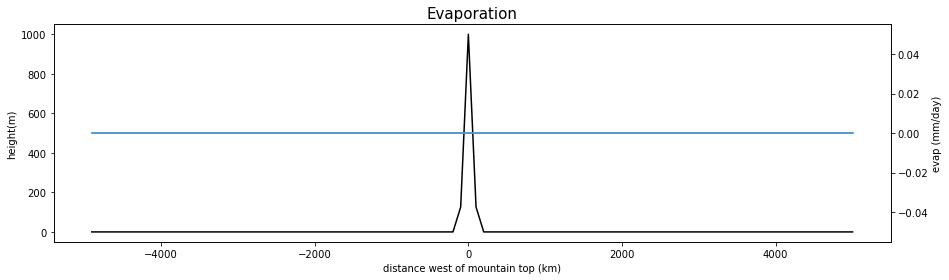

In [27]:
_,ax2 = plotsection(hgt)
dist=(50-hgt.west_east)*100
ax2.set_ylabel("evap (mm/day)")
ax2.plot(dist,drychannel.HFX.isel(Time=slice(200,400)).mean(['south_north','Time']),color='orange')
ax2.plot(dist,drychannel.LH.isel(Time=slice(200,400)).mean(['south_north','Time']),color='dodgerblue')

ax2.set_title("Evaporation", fontsize=15)


Text(0.5, 1.0, 'Evaporation')

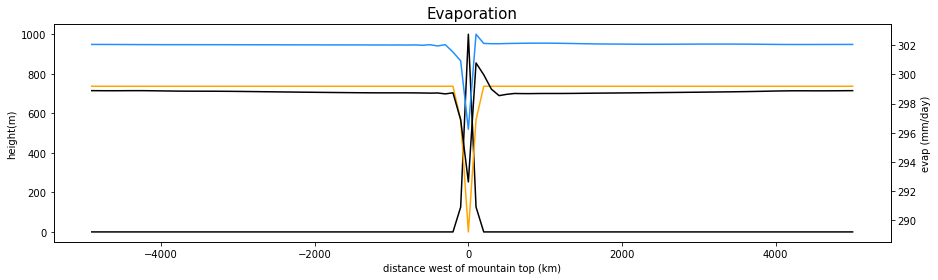

In [12]:
_,ax2 = plotsection(hgt)
dist=(50-hgt.west_east)*100
ax2.set_ylabel("evap (mm/day)")
ax2.plot(dist,drychannel.SST.isel(Time=slice(200,400)).mean(['south_north','Time']),color='orange')
ax2.plot(dist,drychannel.T2.isel(Time=slice(200,400)).mean(['south_north','Time']),color='dodgerblue')
ax2.plot(dist,drychannel.T2.isel(Time=slice(1,2)).mean(['south_north','Time']),color='k')

ax2.set_title("Evaporation", fontsize=15)


## Winds, days 50-100

In [67]:
hgt.isel(west_east=50).load()

<xarray.DataArray 'HGT' ()>
array(1000., dtype=float32)
Coordinates:
    XLAT     float32 10.0
    XLONG    float32 50.0
    XTIME    datetime64[ns] 1970-06-30
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Terrain Height
    units:        m
    stagger:

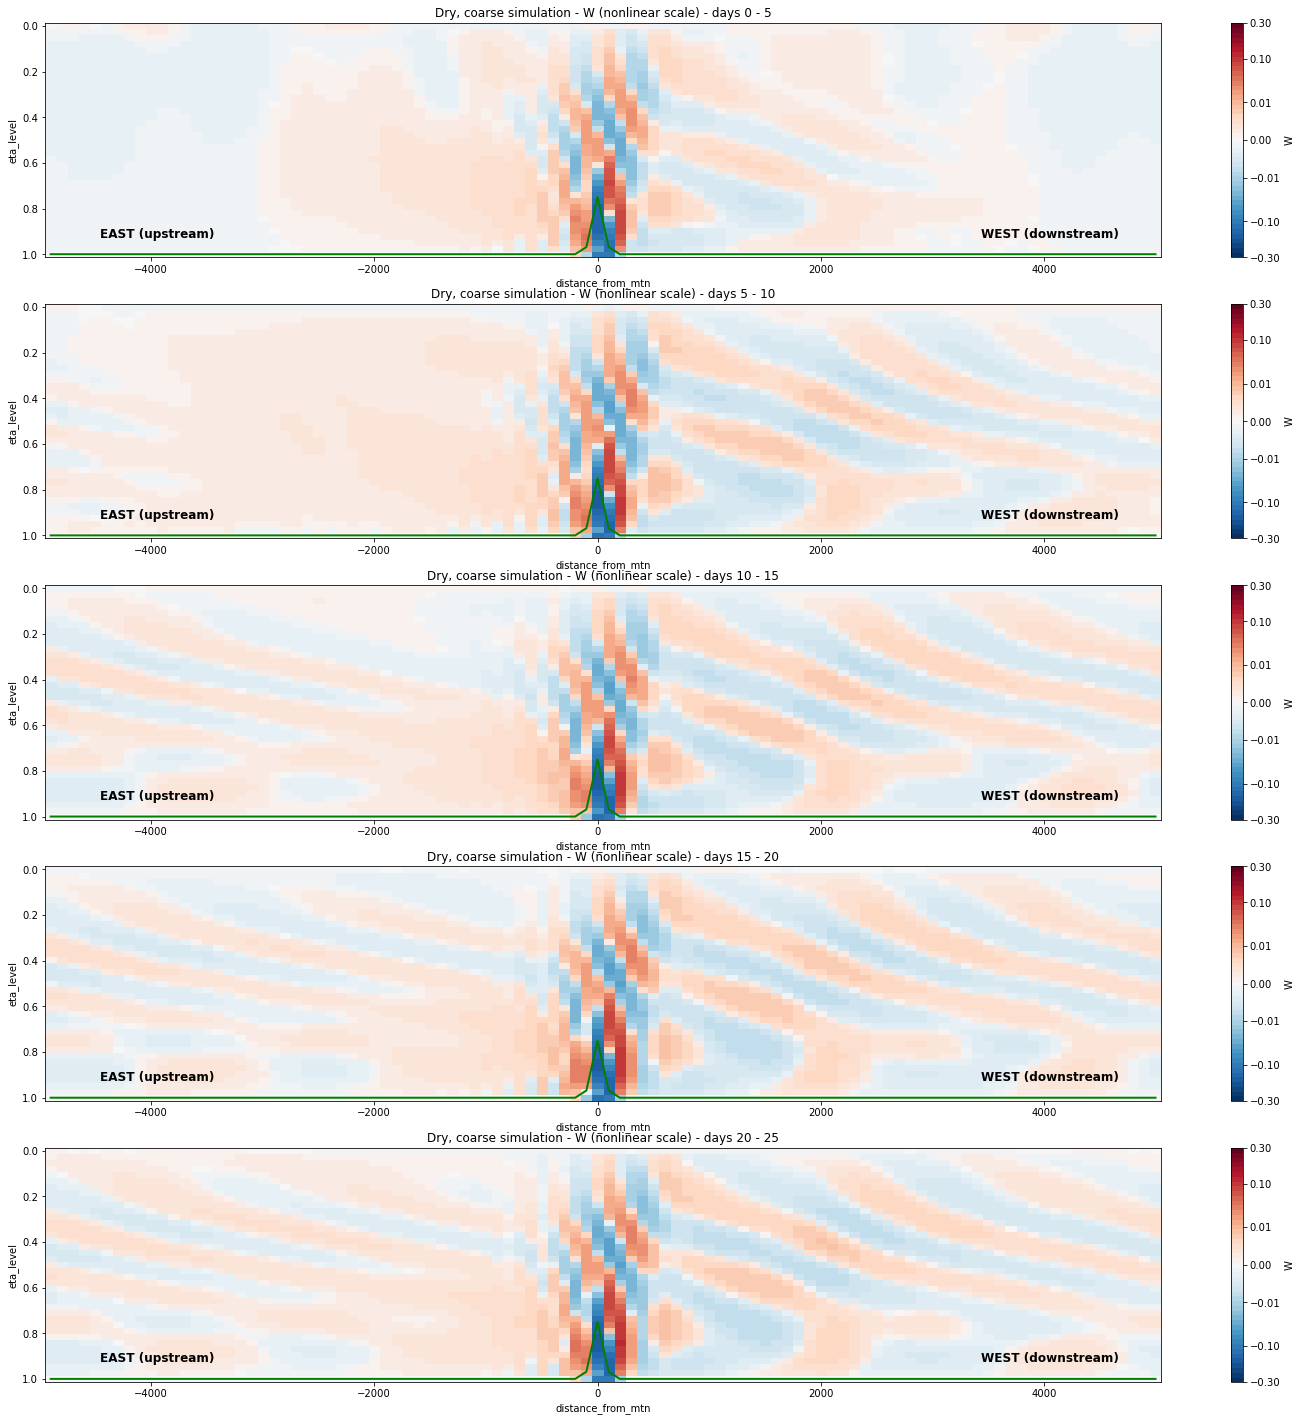

In [19]:
w_plot_allt = drychannel2.W.mean("south_north").assign_coords({'distance_from_mtn':(50-hgt.west_east)*100,'eta_level':drychannel2.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

_,axx=plt.subplots(5,1,figsize=(25,25))

n=5
for i in range(5):
    ax=axx[i]
    w_plot_allt.isel(Time=slice(4*i*n,4*(i+1)*n)).mean('Time').plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    ax.plot(w_plot_allt.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
    add_text(ax)
    ax.set_title("Dry, coarse simulation - W (nonlinear scale) - days %i - %i"%(i*n,(i+1)*n))

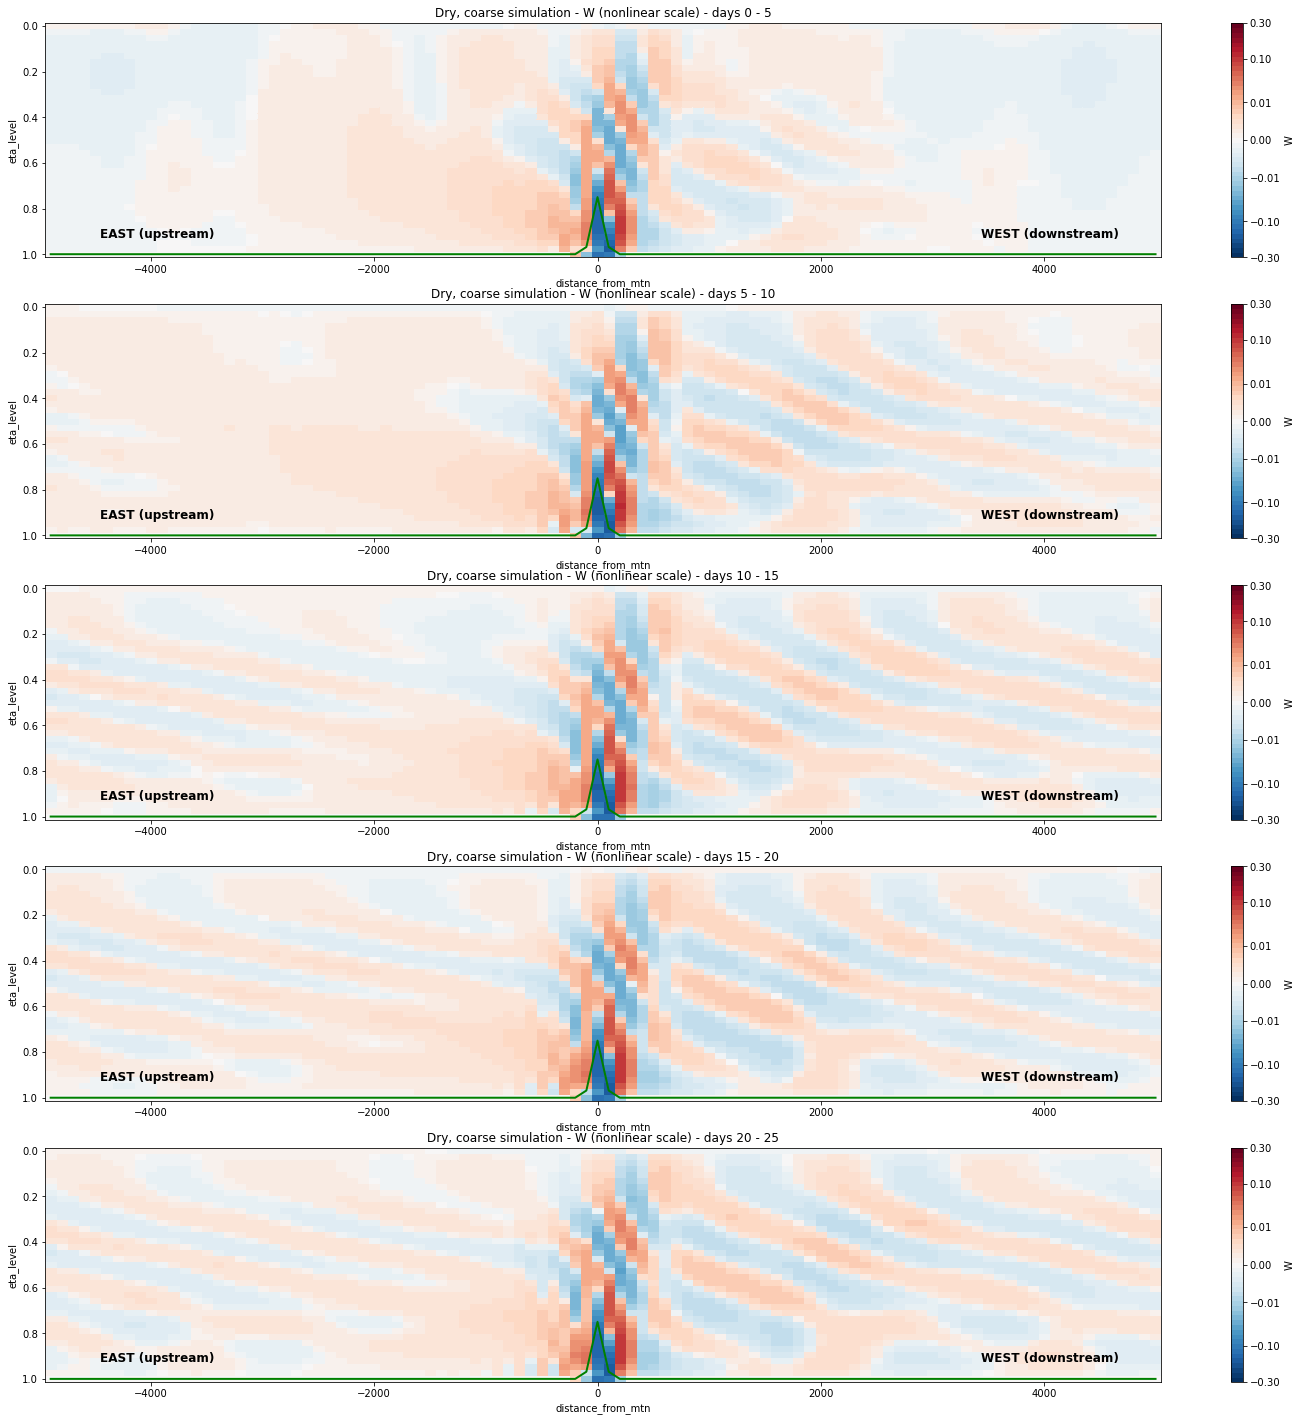

In [68]:
w_plot_allt = drychannel.W.mean("south_north").assign_coords({'distance_from_mtn':(50-hgt.west_east)*100,'eta_level':drychannel.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

_,axx=plt.subplots(5,1,figsize=(25,25))

n=5
for i in range(5):
    ax=axx[i]
    w_plot_allt.isel(Time=slice(4*i*n,4*(i+1)*n)).mean('Time').plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
    add_text(ax)
    ax.set_title("Dry, coarse simulation - W (nonlinear scale) - days %i - %i"%(i*n,(i+1)*n))

In [41]:
%%time
u = drychannel.U.isel(Time=slice(200,720)).mean(["Time","south_north"]).persist()
v = drychannel.V.isel(Time=slice(200,720)).mean(["Time","south_north_stag"]).persist()
w = drychannel.W.isel(Time=slice(200,720)).mean(["Time","south_north"]).persist()

CPU times: user 363 ms, sys: 1.91 s, total: 2.27 s
Wall time: 3.68 s


In [49]:
w_plot=w.assign_coords({'distance_from_mtn':(50-hgt.west_east)*100,'eta_level':drychannel.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'})

Text(0.5, 1.0, 'Dry, coarse simulation - W (nonlinear scale)')

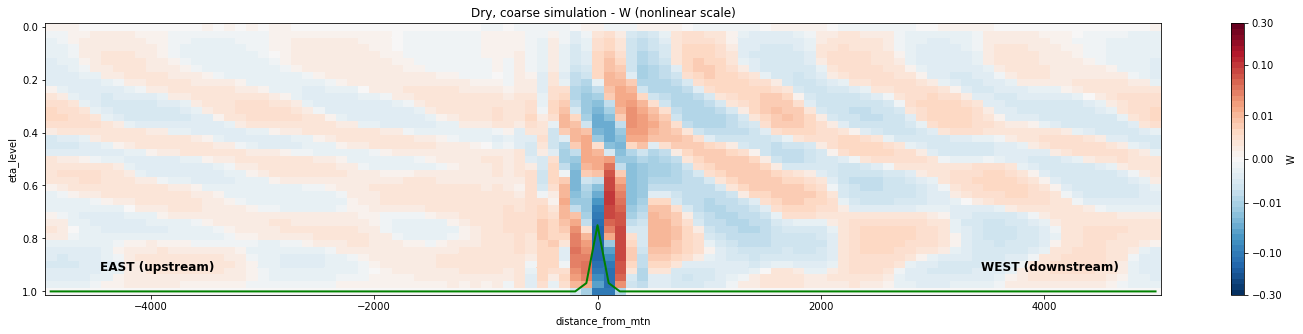

In [59]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Dry, coarse simulation - W (nonlinear scale)")


Text(0.5, 1.0, 'Fully interactive high res simulation - V')

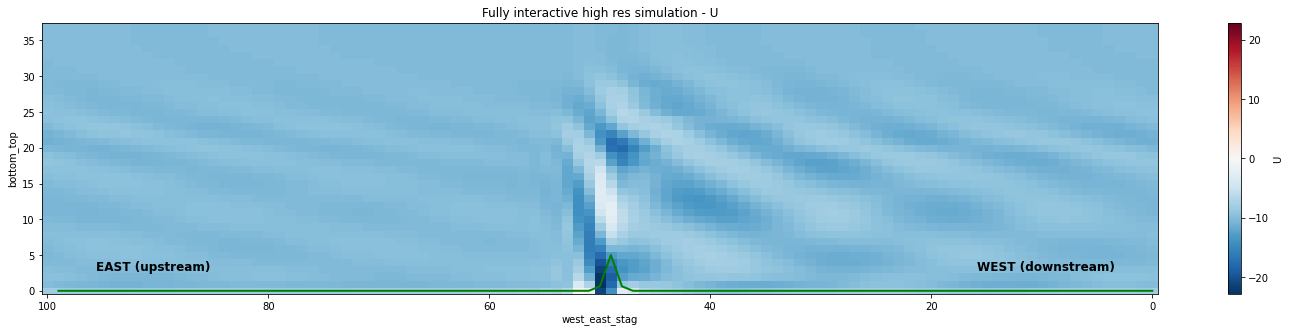

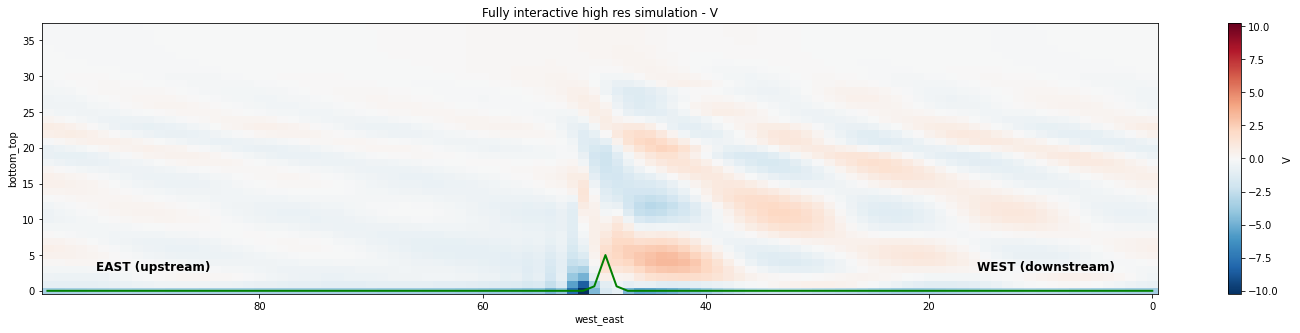

In [43]:
_,ax=plt.subplots(1,1,figsize=(25,5))
u.plot(ax=ax, x='west_east_stag',xincrease=False)#, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - U")

_,ax=plt.subplots(1,1,figsize=(25,5))
v.plot(ax=ax, x='west_east',xincrease=False)#, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hrchannel.west_east, hgt[::-1]/200,color='g',linewidth=2)
add_text(ax)
ax.set_title("Fully interactive high res simulation - V")


# High res

## Soundings

In [9]:
sigma = dryhrchannel.ZNU.isel(Time=-1)

Text(0.5, 1.0, 'domain-mean potential temperature')

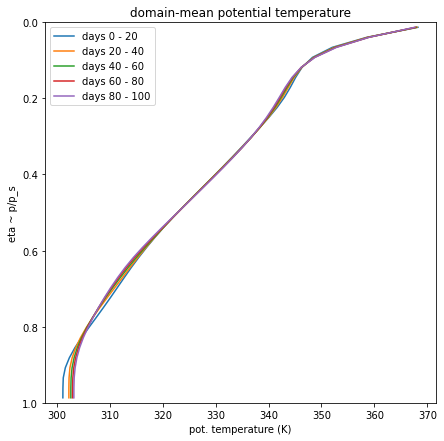

In [10]:
fig, ax = plt.subplots(1,1,figsize=(7,7))

n=20
for i in range(5):
    ax.plot(300+dryhrchannel.T.isel(Time=slice(4*n*i,4*n*(i+1))).mean(['Time','south_north','west_east']),sigma,label='days %i - %i'%(n*i,n*(i+1)))
ax.legend()
ax.set_xlabel('pot. temperature (K)')
ax.set_ylabel('eta ~ p/p_s')
ax.set_ylim(1,0)
ax.set_title('domain-mean potential temperature')


## Winds

In [96]:
%time wrms_moist=xr.ufuncs.sqrt((hrchannel.W.isel(Time=slice(300,350))**2).mean(['Time','south_north'])).persist()
%time wrms_dry  =xr.ufuncs.sqrt((dryhrchannel.W.isel(Time=slice(300,350))**2).mean(['Time','south_north'])).persist()
#wrms.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W_PL.rms.days50-200.nc')

CPU times: user 2.93 s, sys: 9.17 s, total: 12.1 s
Wall time: 9.64 s
CPU times: user 2.34 s, sys: 25 s, total: 27.4 s
Wall time: 24.7 s


In [99]:
def modifw(sim,w):
    return w.assign_coords({'distance_from_mtn':(1635-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

wrms_moist= modifw(hrchannel,wrms_moist)
wrms_dry  = modifw(dryhrchannel,wrms_dry  )

In [11]:
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()

CPU times: user 15.7 s, sys: 18.4 s, total: 34.1 s
Wall time: 33.6 s


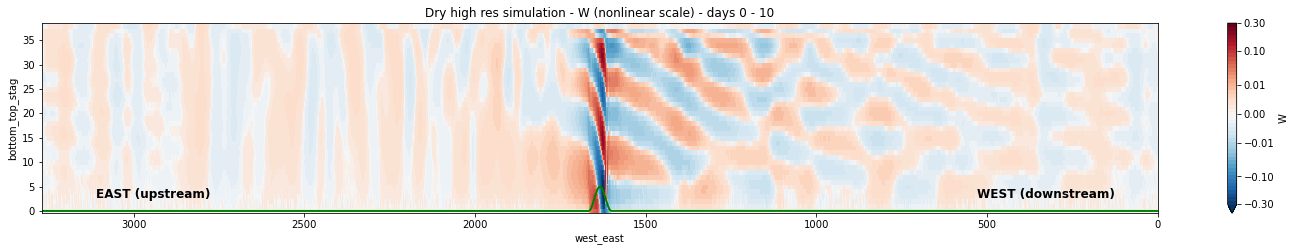

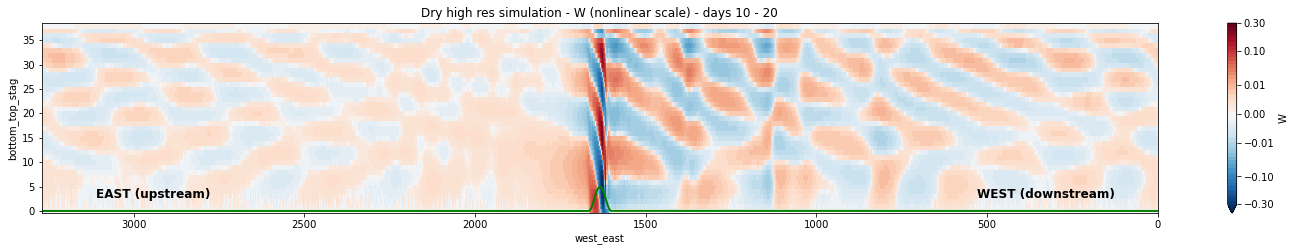

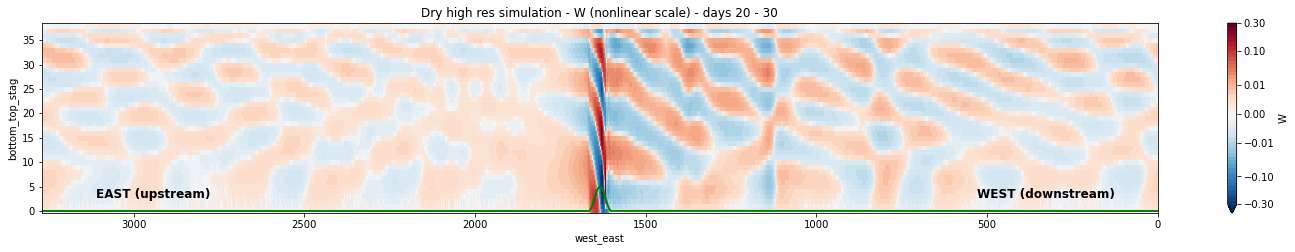

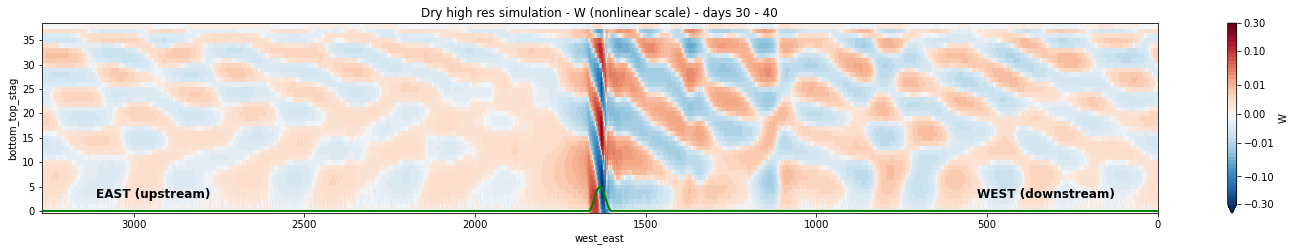

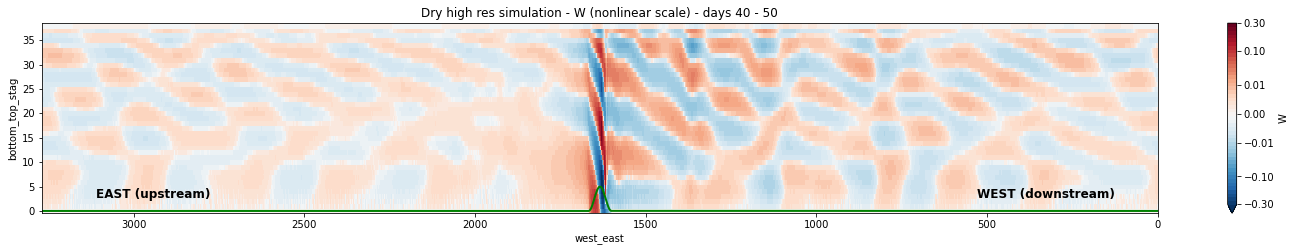

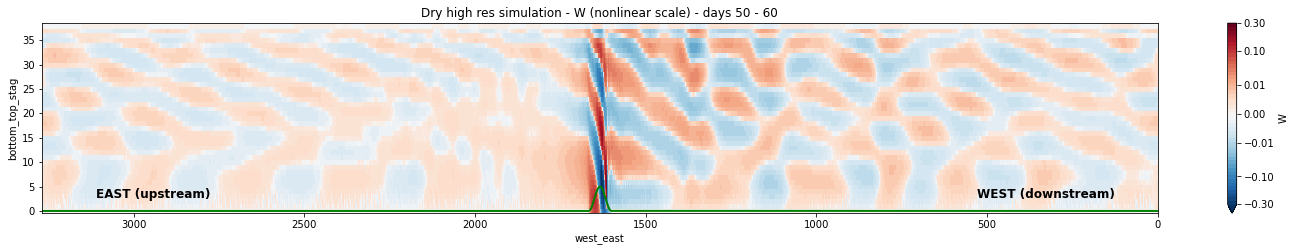

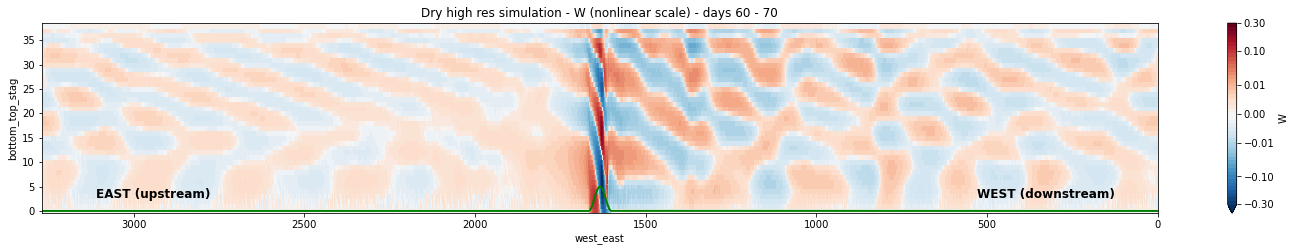

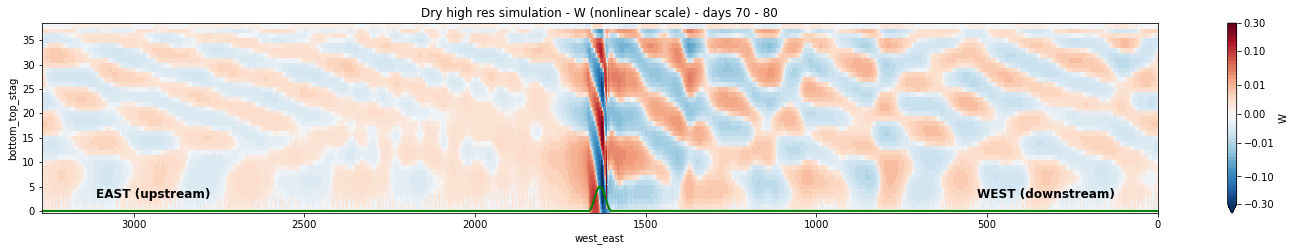

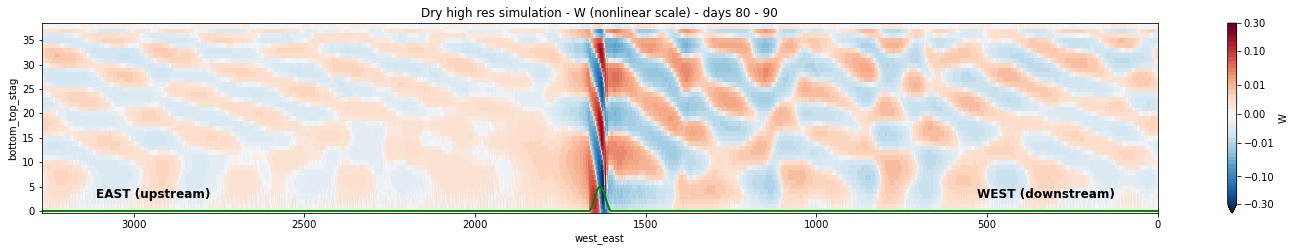

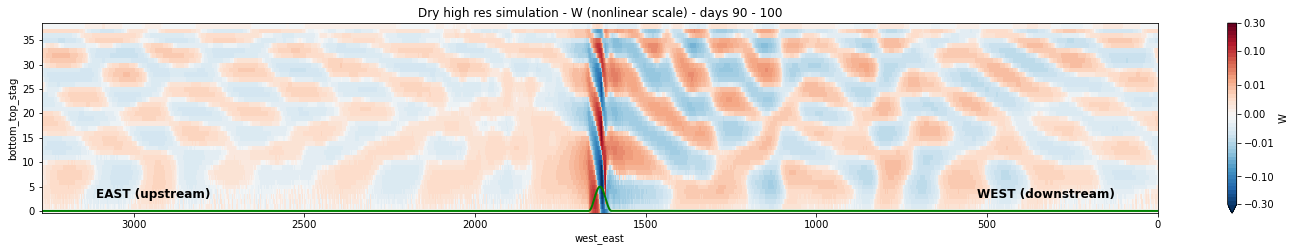

In [15]:
%%time
w_spinup=[]
n=10
p=10
for i in range(p):
    w_spinup.append(dryhrchannel.W.isel(Time=slice(n*4*i,n*4*(i+1))).mean(["Time","south_north"]).persist())
    _,ax=plt.subplots(1,1,figsize=(25,3.5))
    w_spinup[-1].plot(ax=ax, x='west_east',xincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
    ax.plot(dryhrchannel.west_east, hrhgt[::-1]/200,color='g',linewidth=2)
    add_text(ax)
    ax.set_title("Dry high res simulation - W (nonlinear scale) - days %i - %i"%(n*i,n*(i+1)))

In [10]:
def open_wplot(sim,path):
    w=xr.open_dataarray(path)
    return w.assign_coords({'distance_from_mtn':(1635-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

w_moist=open_wplot(hrchannel,"/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.days50-200.nc")
w_dry=open_wplot(dryhrchannel,"/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.days50-100.nc")


In [27]:
zb = dryhrchannel.PHB[0,:,0]/9.81
zb = zb.assign_coords({'distance_from_mtn':(1635-zb.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()
eta_1500 = ((zb-1500)**2).argmin(dim='bottom_top_stag').compute()
eta_1500 = dryhrchannel.ZNW.isel(Time=-1)[eta_1500].load()

In [28]:
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
lfc = hrchannel_capecin[3].isel(Time=slice(200,800)).mean(['Time','south_north'])
lfc=lfc.assign_coords({'distance_from_mtn':(1635-lfc.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()
eta_lfc = ((zb-lfc)**2).argmin(dim='bottom_top_stag').compute()
eta_lfc = dryhrchannel.ZNW.isel(Time=-1)[eta_lfc].load()

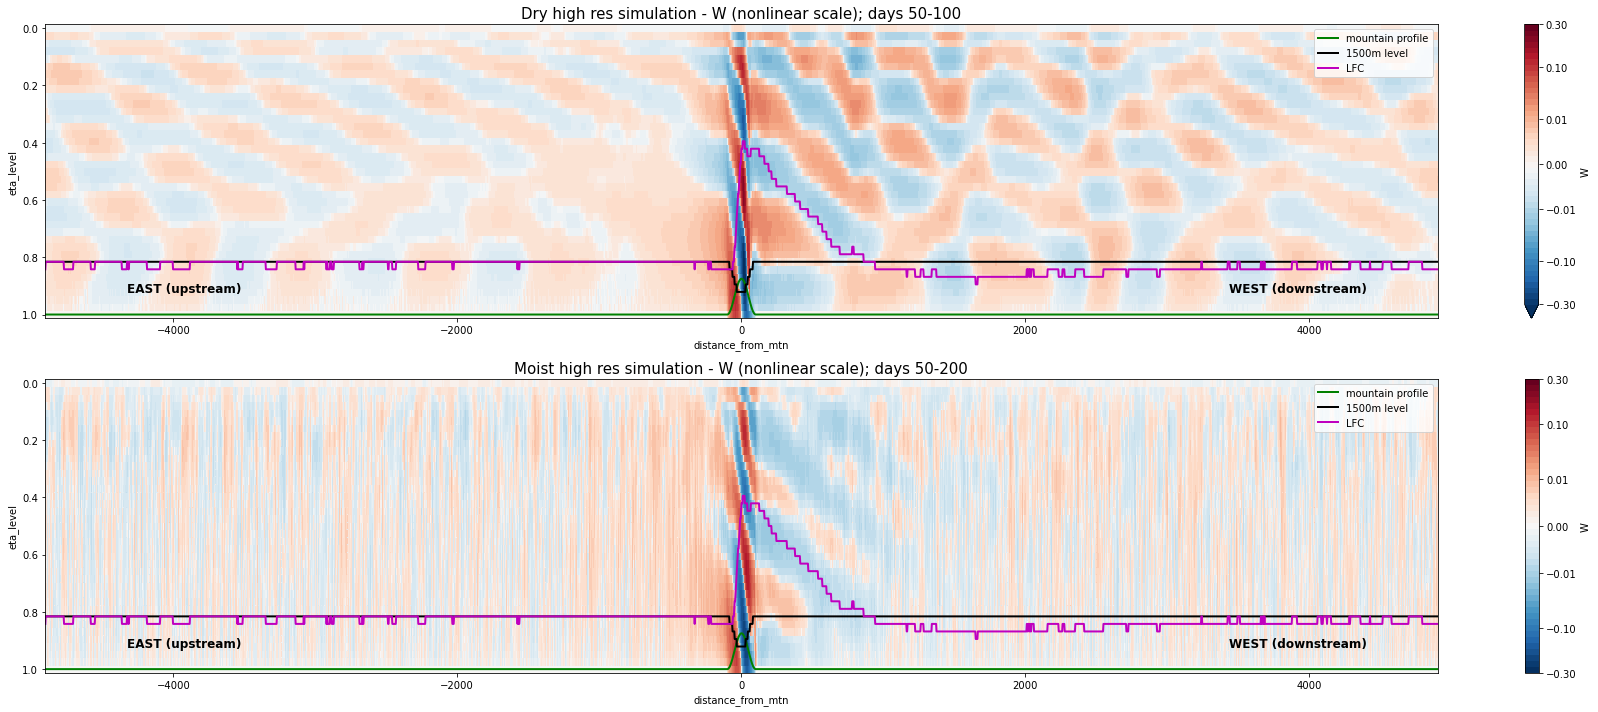

In [29]:

fig,ax=plt.subplots(2,1,figsize=(25,10))
w_dry.plot(ax=ax[0],  yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
w_moist.plot(ax=ax[1],yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

for a in ax:
    a.plot(w_dry.distance_from_mtn, 1-hrhgt[::-1]/8e3,color='g',linewidth=2, label = 'mountain profile')
    a.plot(eta_1500.distance_from_mtn, eta_1500,color='k',linewidth=2      , label="1500m level")
    a.plot(eta_lfc.distance_from_mtn, eta_lfc,color='m',linewidth=2        , label="LFC")
    add_text(a)
    a.legend(loc='upper right')

    
ax[0].set_title("Dry high res simulation - W (nonlinear scale); days 50-100", fontsize=15)
ax[1].set_title("Moist high res simulation - W (nonlinear scale); days 50-200", fontsize=15)
fig.tight_layout()

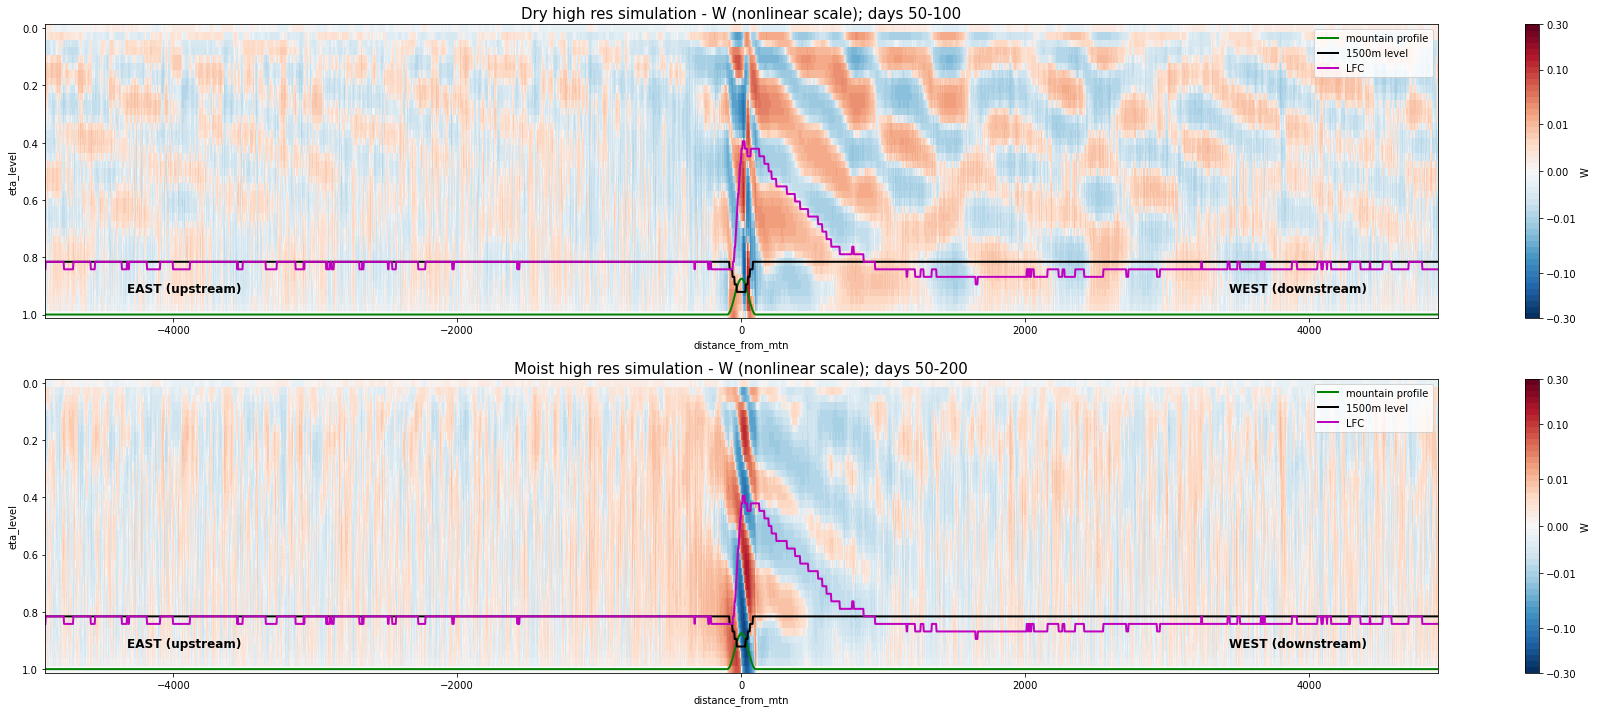

In [149]:

fig,ax=plt.subplots(2,1,figsize=(25,10))
(w_dry-w_moist).plot(ax=ax[0],  yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
w_moist.plot(ax=ax[1],yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

for a in ax:
    a.plot(w_dry.distance_from_mtn, 1-hrhgt[::-1]/8e3,color='g',linewidth=2, label = 'mountain profile')
    a.plot(eta_1500.distance_from_mtn, eta_1500,color='k',linewidth=2      , label="1500m level")
    a.plot(eta_lfc.distance_from_mtn, eta_lfc,color='m',linewidth=2        , label="LFC")
    add_text(a)
    a.legend(loc='upper right')

    
ax[0].set_title("Dry high res simulation - W (nonlinear scale); days 50-100", fontsize=15)
ax[1].set_title("Moist high res simulation - W (nonlinear scale); days 50-200", fontsize=15)
fig.tight_layout()

In [24]:
4/255*1*0.7*340/100

0.03733333333333333

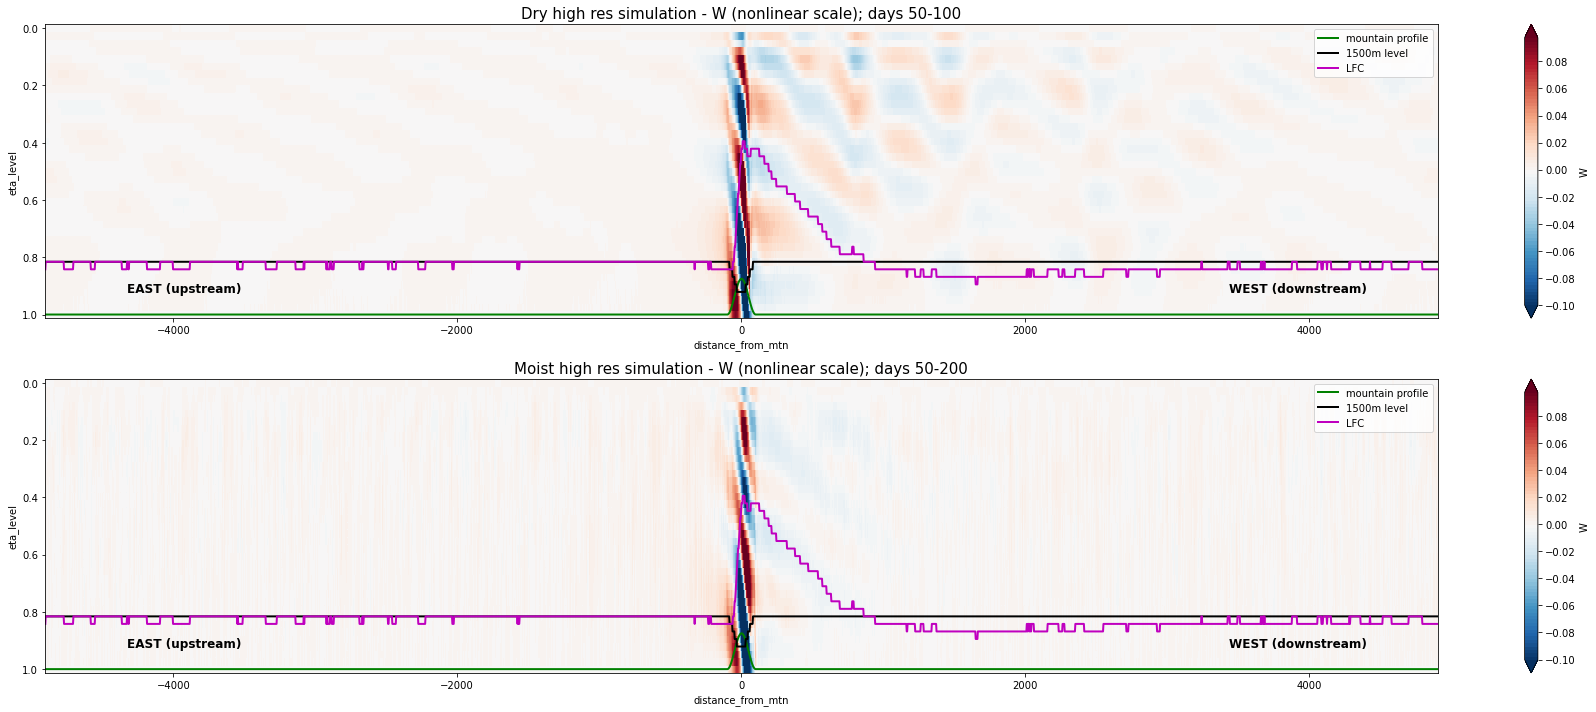

In [41]:

fig,ax=plt.subplots(2,1,figsize=(25,10))
w_dry.plot(ax=ax[0],  yincrease=False, levels=np.arange(-0.1,0.1,2.5e-3))
w_moist.plot(ax=ax[1],yincrease=False, levels=np.arange(-0.1,0.1,2.5e-3))

for a in ax:
    a.plot(w_dry.distance_from_mtn, 1-hrhgt[::-1]/8e3,color='g',linewidth=2, label = 'mountain profile')
    a.plot(eta_1500.distance_from_mtn, eta_1500,color='k',linewidth=2      , label="1500m level")
    a.plot(eta_lfc.distance_from_mtn, eta_lfc,color='m',linewidth=2        , label="LFC")
    add_text(a)
    a.legend(loc='upper right')

    
ax[0].set_title("Dry high res simulation - W (nonlinear scale); days 50-100", fontsize=15)
ax[1].set_title("Moist high res simulation - W (nonlinear scale); days 50-200", fontsize=15)
fig.tight_layout()

In [82]:
hrchannel.PB[0,10,0,0].load()#/9.81
#hrchannel.ZNW[0,17].load()

<xarray.DataArray 'PB' ()>
array(75483.12, dtype=float32)
Coordinates:
    XLAT     float32 20.0
    XLONG    float32 0.0
    XTIME    datetime64[ns] 1970-01-01
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  BASE STATE PRESSURE
    units:        Pa
    stagger:

In [ ]:
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannelprecip=hrchannelprecip[200:].mean(['Time','south_north']).assign_coords({'distance_from_mtn':(1635-hrchannelprecip.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'})

Text(0.5, 1.0, 'W & precip')

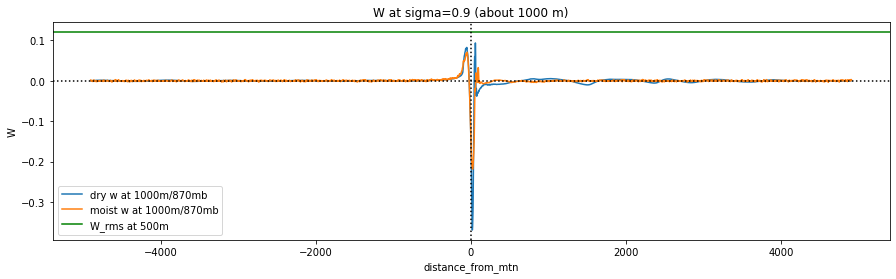

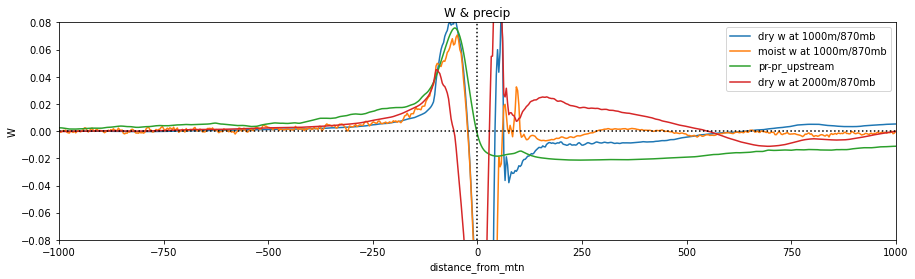

In [95]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
w_dry[5,:].plot(ax=ax, x='distance_from_mtn',label='dry w at 1000m/870mb')
w_moist[5,:].plot(ax=ax, x='distance_from_mtn',label='moist w at 1000m/870mb')

ax.axhline(0.12,color='green',label="W_rms at 500m")
ax.axhline(0.,color='k',linestyle=":")
ax.axvline(0.,color='k',linestyle=":")
ax.legend()
ax.set_title("W at sigma=0.9 (about 1000 m)")

fig,ax=plt.subplots(1,1,figsize=(15,4))
w_dry[5,:].plot(ax=ax, x='distance_from_mtn',label='dry w at 1000m/870mb')
w_moist[5,:].plot(ax=ax, x='distance_from_mtn',label='moist w at 1000m/870mb')
((hrchannelprecip-4.5)/200).plot(ax=ax, x='distance_from_mtn',label='pr-pr_upstream')
w_dry[10,:].plot(ax=ax, x='distance_from_mtn',label='dry w at 2000m/870mb')
ax.set_ylim(-0.08,0.08)
ax.set_xlim(-1000,1000)
ax.axhline(0.,color='k',linestyle=":")
ax.axvline(0.,color='k',linestyle=":")
ax.legend()
ax.set_title("W & precip")

Text(0.5, 1.0, 'W at sigma=0.9 (about 1000 m)')

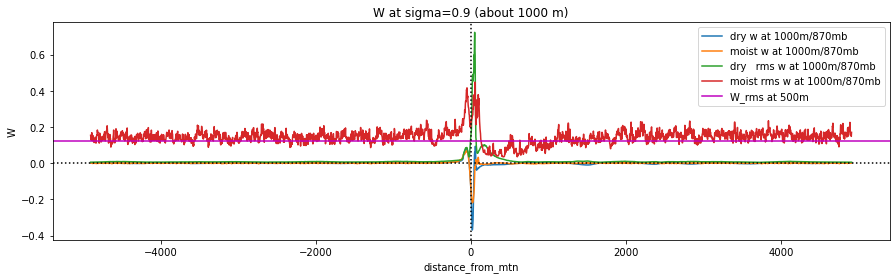

In [150]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
w_dry[5,:].plot(ax=ax, x='distance_from_mtn',label='dry w at 1000m/870mb')
w_moist[5,:].plot(ax=ax, x='distance_from_mtn',label='moist w at 1000m/870mb')

wrms_dry[5,:].plot(ax=ax, x='distance_from_mtn'  ,label='dry   rms w at 1000m/870mb')
wrms_moist[5,:].plot(ax=ax, x='distance_from_mtn',label='moist rms w at 1000m/870mb')

ax.axhline(0.12,color='m',label="W_rms at 500m")
ax.axhline(0.,color='k',linestyle=":")
ax.axvline(0.,color='k',linestyle=":")
ax.legend()
ax.set_title("W at sigma=0.9 (about 1000 m)")


Text(0.5, 1.0, 'Moist high res simulation - W (nonlinear scale); days 50-200 || CONTOURS : w_dry=0')

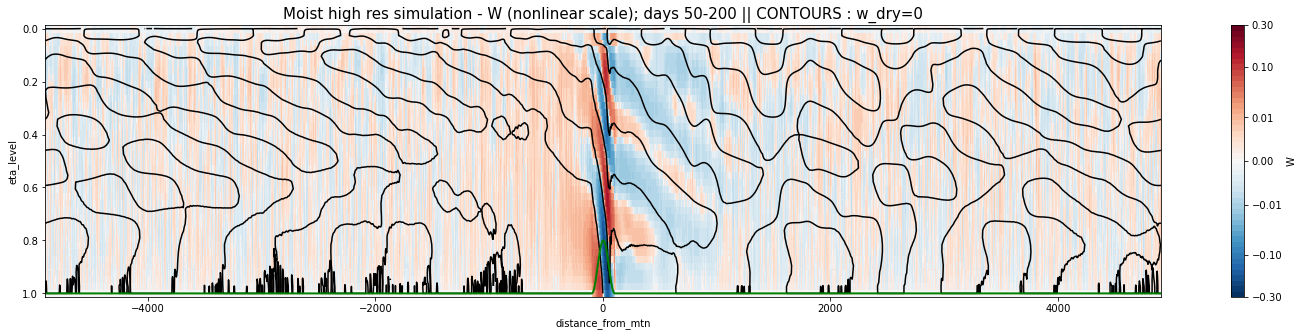

In [43]:

fig,ax=plt.subplots(1,1,figsize=(25,5))
w_dry.plot.contour(ax=ax, yincrease=False, levels=[0.],colors='k')
w_moist.plot(ax=ax,       yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})

ax.plot(w_dry.distance_from_mtn, 1-hrhgt[::-1]/5e3,color='g',linewidth=2)
    
ax.set_title("Moist high res simulation - W (nonlinear scale); days 50-200 || CONTOURS : w_dry=0", fontsize=15)



## Fitting convective time scale

In [11]:
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')
hrchannelprecip=hrchannelprecip[200:].mean(['Time','south_north']).assign_coords({'distance_from_mtn':(1635-hrchannelprecip.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'})
hrchannel_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d

In [12]:
cape=hrchannel_capecin[0].isel(Time=slice(200,400)).mean(['south_north','Time'])
cape=cape.assign_coords({'distance_from_mtn':(1635-cape.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'})
pr = hrchannelprecip
tauc=cape/(2.26e6*pr/86400/10000)
tauc=tauc/tauc[2000:3000].mean()

In [20]:
H=0.01
tau_lcl = H/(H+w_dry[5,:])

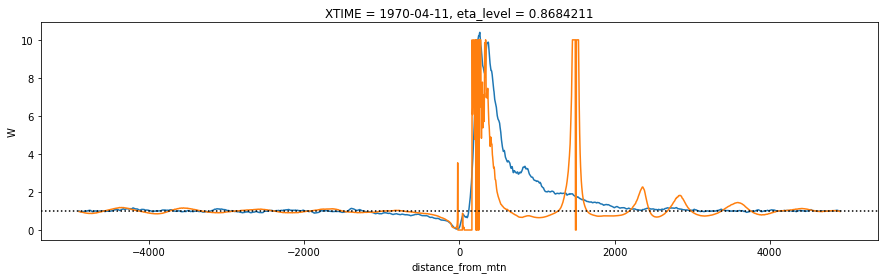

In [21]:
fig,ax=plt.subplots(1,1,figsize=(15,4))
tauc.plot()
np.maximum(np.minimum(tau_lcl,10),0.).plot()
ax.axhline(1.,color='k',linestyle=':')
#ax.set_ylim(-5,5)

# Precip predicted by dry motion VS moist simulation precip

In [90]:
plevs = np.arange(125.,990.,20.)[::-1]
plevs

array([985., 965., 945., 925., 905., 885., 865., 845., 825., 805., 785.,
       765., 745., 725., 705., 685., 665., 645., 625., 605., 585., 565.,
       545., 525., 505., 485., 465., 445., 425., 405., 385., 365., 345.,
       325., 305., 285., 265., 245., 225., 205., 185., 165., 145., 125.])

In [99]:
w_3d=dryhrchannel.W.isel(Time=slice(200,401)).mean("Time").persist()
w_3d = xr.DataArray(wrf.destagger(w_3d,0),coords=dryhrchannel.T.isel(Time=0).coords)
w_3d_p = wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-04-01_06_00_00'),
                     w_3d,"pressure",plevs
                    ).rename({'interp_level':'pressure'}).fillna(0.)
w_dry_p = w_3d_p.mean('south_north')

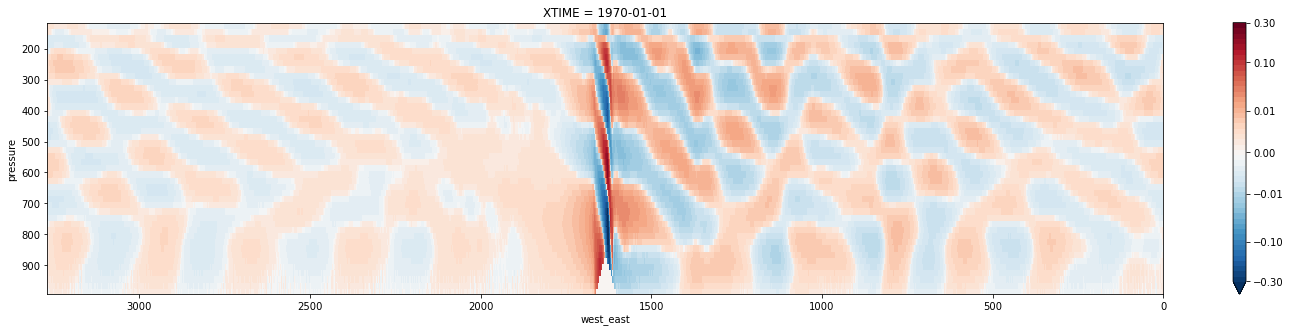

In [100]:
fig,ax=plt.subplots(1,1,figsize=(25,5))
w_dry_p.plot(ax=ax,xincrease=False,yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})


In [96]:
def interpolate(var):
    var=var.isel(Time=slice(200,401)).mean("Time")
    var_p = wrf.vinterp(Dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/wrfout_d01_1970-04-01_06_00_00'),
                     var,"pressure",plevs
                    ).rename({'interp_level':'pressure'}).fillna(0.)
    return var_p.mean('south_north').persist()

In [105]:
rho_dry_p = interpolate(dryhrchannel.RHO)
Theta_dry_p = interpolate(dryhrchannel.T)

In [114]:
omega_dry_p = -rho_dry_p*9.81*w_dry_p
T_dry_p=(300.+Theta_dry_p)*(Theta_dry_p.pressure/1000)**0.286
ps_dry = dryhrchannel.PSFC.isel(Time=slice(200,401)).mean(['Time','south_north'])

In [124]:
precip = xr.apply_ufunc(scaling,omega_dry_p.load(),T_dry_p.load(),T_dry_p.pressure.load()*100,ps_dry.load(),input_core_dims=[['pressure'], ['pressure'], ['pressure'],[]],vectorize=True)

In [129]:
hrchannel10precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc")

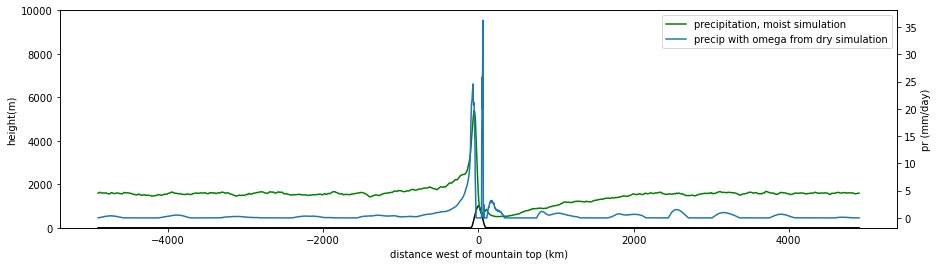

In [133]:
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.plot(hrdist,hrhgt,color='k')
ax2 = ax.twinx()
ax2.set_ylabel("pr (mm/day)")
ax.set_ylim(0,10000)

ax2.plot(hrdist,hrchannel10precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='precipitation, moist simulation')
ax2.plot(hrdist,86400*np.maximum(precip,0.),label="precip with omega from dry simulation")

ax2.legend()

In [137]:
from orographicPrecipitation.precip_extremes_scaling import *
def scaling_nonnegative(omega, temp, plev, ps):

    try:
        if plev[0]<plev[1]:
            raise ValueError('unexpected ordering of pressure levels')
    except ValueError:
        raise
        
    # criterion for identifying tropopause
    crit_lapse_rate = 0.002 # (k/m) for tropopause
    plev_mask = 0.05e5 # (Pa) exclude levels above this as a fail-safe

    dqsat_dp, dqsat_dT,_ = sat_deriv(plev, temp)
    es, qsat, rsat, latent_heat = saturation_thermodynamics(temp, plev, 'era')
    lapse_rate = moist_adiabatic_lapse_rate(temp, plev, 'era')

    # virtual temperature
    temp_virtual = temp*(1.0+qsat*(pars('gas_constant_v')/pars('gas_constant')-1.0))

    # density
    rho = plev/pars('gas_constant')/temp_virtual

    dT_dp = lapse_rate/pars('gravity')/rho

    # find derivative of saturation specific humidity with respect to pressure along 
    # a moist adiabat at the given temperature and pressure for each level
    dqsat_dp_total = dqsat_dp+dqsat_dT*dT_dp

    # mask above tropopause using simple lapse rate criterion
    dT_dp_env = np.gradient(temp, plev)
    lapse_rate_env = dT_dp_env*rho*pars('gravity')

    itrop = np.where(lapse_rate_env>crit_lapse_rate)[0]
    if itrop.size!=0:
        if np.max(itrop)+1<len(plev):
            dqsat_dp_total[np.max(itrop)+1:]=0

    # mask above certain level as fail safe
    dqsat_dp_total[plev<plev_mask]=0

    dqsat_dp_total_omega = dqsat_dp_total*omega

    # replaces nans with zeros as subsurface values should not contribute
    # to the column integral
    dqsat_dp_total_omega[np.isnan(dqsat_dp_total_omega)]=0

    # also use surface pressure to zero subsurface values
    kbot = plev>ps
    if any(kbot):
        dqsat_dp_total_omega[kbot]=0
       
    # get rid of negative values
    dqsat_dp_total_omega[dqsat_dp_total_omega>=0.]=0

    # integrate in the vertical
    precip = -integrate(-dqsat_dp_total_omega,plev)/pars('gravity')

    return precip

In [138]:
precip_nn = xr.apply_ufunc(scaling_nonnegative,omega_dry_p.load(),T_dry_p.load(),T_dry_p.pressure.load()*100,ps_dry.load(),input_core_dims=[['pressure'], ['pressure'], ['pressure'],[]],vectorize=True)

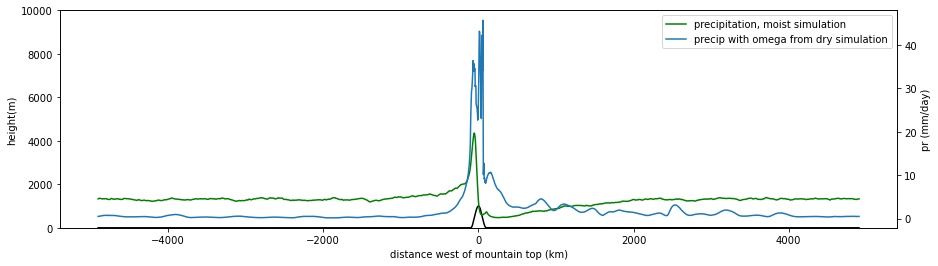

In [139]:
hrhgt = dryhrchannel.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.plot(hrdist,hrhgt,color='k')
ax2 = ax.twinx()
ax2.set_ylabel("pr (mm/day)")
ax.set_ylim(0,10000)

ax2.plot(hrdist,hrchannel10precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='precipitation, moist simulation')
ax2.plot(hrdist,86400*np.maximum(precip_nn,0.),label="precip with omega from dry simulation")

ax2.legend()

# Thermodynamic equation breakdown

## Monthly means, pressure levels

In [10]:
def select_time(ds):
    return ds.isel(Time=slice(200,300))

In [11]:
%%time
# Advective term
meandThetadx = interp_pressure(select_time(dryhrchannel.T).mean('Time')).differentiate('west_east')/3000   # in K/meter
meandThetady = interp_pressure(select_time(dryhrchannel.T).mean('Time')).differentiate('south_north')/3000 # in K/meter
meandestag_U = interp_pressure(wrf.destagger(select_time(dryhrchannel.U).mean('Time'),2,meta=True))
meandestag_V = interp_pressure(wrf.destagger(select_time(dryhrchannel.V).mean('Time'),1,meta=True))

meanugradTheta = ((meandestag_U*meandThetadx+meandestag_V*meandThetady)*86400).persist() #in K/day
meanudThetadx = ((meandestag_U*meandThetadx)*86400).persist() #in K/day
meanvdThetady = ((meandestag_V*meandThetady)*86400).persist() #in K/day


CPU times: user 28 s, sys: 30.2 s, total: 58.2 s
Wall time: 52.5 s


In [12]:
%%time
# Adiabatic term
meandestag_W = interp_pressure(wrf.destagger(select_time(dryhrchannel.W).mean('Time'),0,meta=True))
meanRHO = interp_pressure(select_time(dryhrchannel.RHO).mean('Time'))
meandThetadp = interp_pressure(select_time(dryhrchannel.T).mean('Time')).differentiate('pressure')/100.

meanomegadThetadp = (-9.81*meanRHO*meandestag_W*meandThetadp*86400).persist() #in K/day

CPU times: user 19.9 s, sys: 47.9 s, total: 1min 7s
Wall time: 54.5 s


In [13]:
# diabatic heating term
meanQdiab_pi = meanugradTheta + meanomegadThetadp

In [14]:
def dsmean4(ds):
    return -ds.sel(west_east=slice(1500,2000)).fillna(0.).integrate('pressure').mean('south_north')/np.abs(ds.pressure[0]-ds.pressure[-1])

In [15]:
%%time
meanplot2=dsmean4(meanugradTheta).load()
meanplot3=dsmean4(meanomegadThetadp ).load()
meanplot5=dsmean4(meanQdiab_pi  ).load()

CPU times: user 44.3 ms, sys: 0 ns, total: 44.3 ms
Wall time: 43.5 ms


In [19]:
adiab_dry=dsmean4(meanomegadThetadp ).load()
advec_dry=dsmean4(meanugradTheta ).load()
diab_dry=dsmean4(meanQdiab_pi ).load()

(-40.0, 40.0)

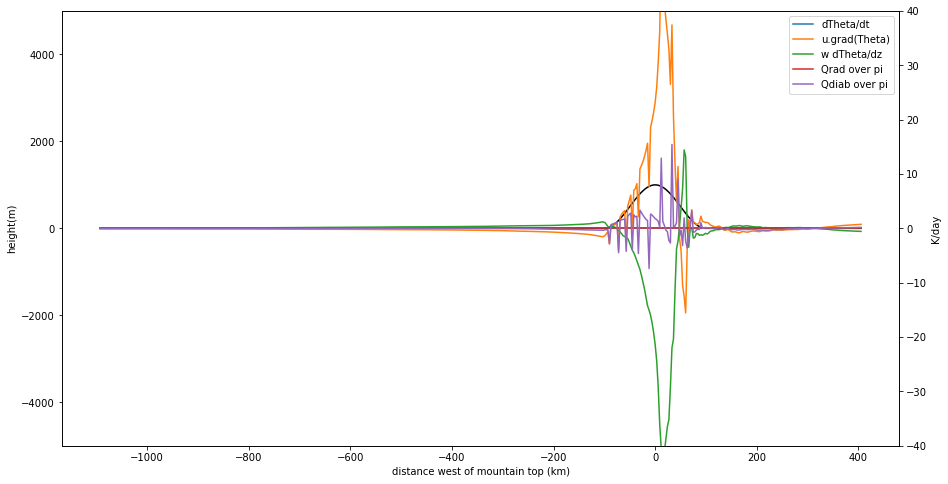

In [20]:
dist=(135-meanplot2.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hrhgt[1500:2000],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, [0.]*len(dist) ,label="dTheta/dt")
ax2.plot(dist, advec_dry ,label="u.grad(Theta)")
ax2.plot(dist, adiab_dry ,label="w dTheta/dz")
ax2.plot(dist, [0.]*len(dist) ,label="Qrad over pi")
ax2.plot(dist, diab_dry ,label="Qdiab over pi")
ax2.legend()
ax2.set_ylim(-40,40)

## Dry vs moist

In [21]:
%%time
# Advective term
meandThetadx_m = interp_pressure(select_time(hrchannel.T).mean('Time')).differentiate('west_east')/3000   # in K/meter
meandThetady_m = interp_pressure(select_time(hrchannel.T).mean('Time')).differentiate('south_north')/3000 # in K/meter
meandestag_U_m = interp_pressure(wrf.destagger(select_time(hrchannel.U).mean('Time'),2,meta=True))
meandestag_V_m = interp_pressure(wrf.destagger(select_time(hrchannel.V).mean('Time'),1,meta=True))

meanugradTheta_m = ((meandestag_U_m*meandThetadx_m+meandestag_V_m*meandThetady_m)*86400).persist() #in K/day

CPU times: user 27.2 s, sys: 58.3 s, total: 1min 25s
Wall time: 1min 20s


In [22]:
%%time
# Adiabatic term
meandestag_W_m = interp_pressure(wrf.destagger(select_time(hrchannel.W).mean('Time'),0,meta=True))
meanRHO_m = interp_pressure(select_time(hrchannel.RHO).mean('Time'))
meandThetadp_m = interp_pressure(select_time(hrchannel.T).mean('Time')).differentiate('pressure')/100.

meanomegadThetadp_m = (-9.81*meanRHO_m*meandestag_W_m*meandThetadp_m*86400).persist() #in K/day

CPU times: user 20.3 s, sys: 1min, total: 1min 20s
Wall time: 1min 8s


In [28]:
meanomegadThetadp_dm = (-9.81*meanRHO*meandestag_W*meandThetadp_m*86400).persist() #in K/day
meanomegadThetadp_md = (-9.81*meanRHO_m*meandestag_W_m*meandThetadp*86400).persist() #in K/day
adiab_dm=dsmean4(meanomegadThetadp_dm ).load()
adiab_md=dsmean4(meanomegadThetadp_md ).load()

In [24]:
adiab_moist=dsmean4(meanomegadThetadp_m ).load()
advec_moist=dsmean4(meanugradTheta_m    ).load()

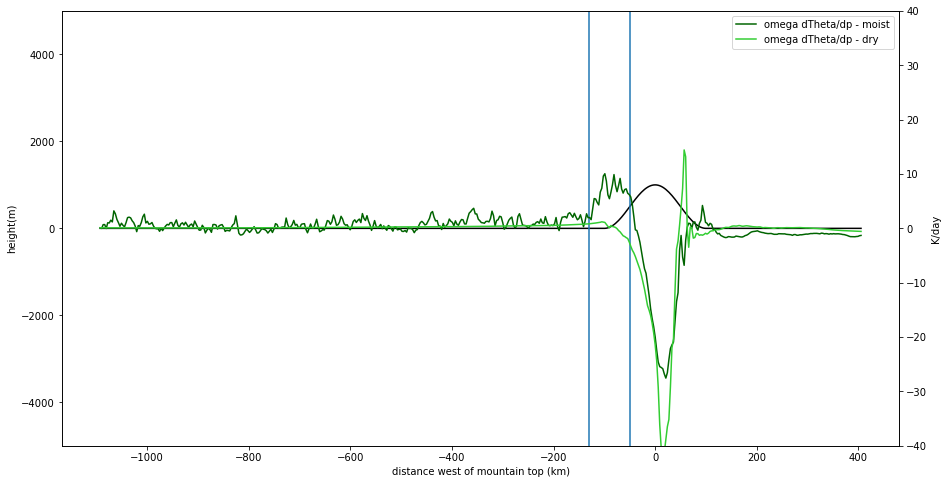

In [25]:
dist=(135-meanplot2.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hrhgt[1500:2000],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, adiab_moist ,label="omega dTheta/dp - moist", color='darkgreen')
ax2.plot(dist, adiab_dry   ,label="omega dTheta/dp - dry"  , color='limegreen')
ax2.legend()
ax2.set_ylim(-40,40)

ax.axvline(-50)
ax.axvline(-130)

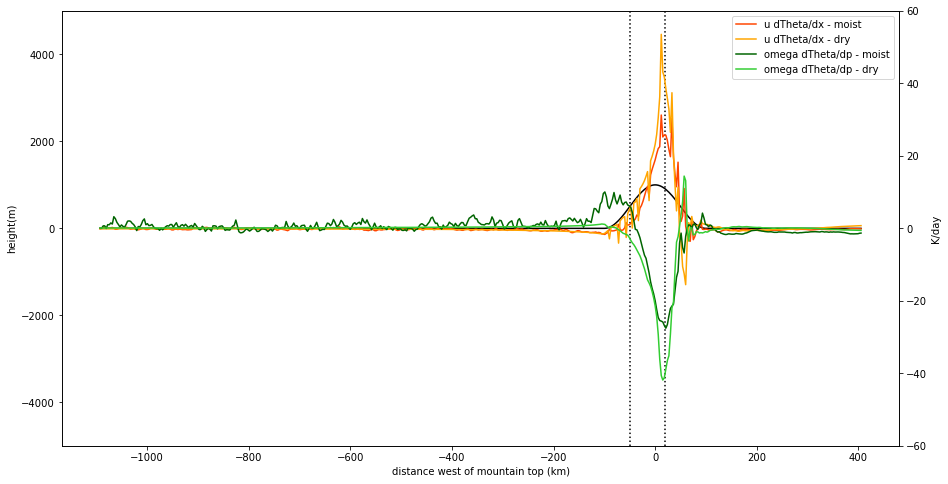

In [33]:
dist=(135-meanplot2.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hrhgt[1500:2000],color='k')
ax2=ax.twinx()

ax2.set_ylabel("K/day")
ax2.plot(dist, advec_moist ,label="u dTheta/dx - moist", color='orangered')
ax2.plot(dist, advec_dry   ,label="u dTheta/dx - dry"  , color='orange')
ax2.plot(dist, adiab_moist ,label="omega dTheta/dp - moist", color='darkgreen')
ax2.plot(dist, adiab_dry   ,label="omega dTheta/dp - dry"  , color='limegreen')
#ax2.plot(dist, adiab_md ,label="omega_moist dTheta/dp_dry", color='darkgreen',linestyle='--')
#ax2.plot(dist, adiab_dm   ,label="omega_dry dTheta/dp_moist"  , color='limegreen',linestyle='--')
ax2.legend()
ax2.set_ylim(-60,60)

ax.axvline(-50,color='k',linestyle=':')
ax.axvline(20,color='k',linestyle=':')

## Dry vs moist soundings

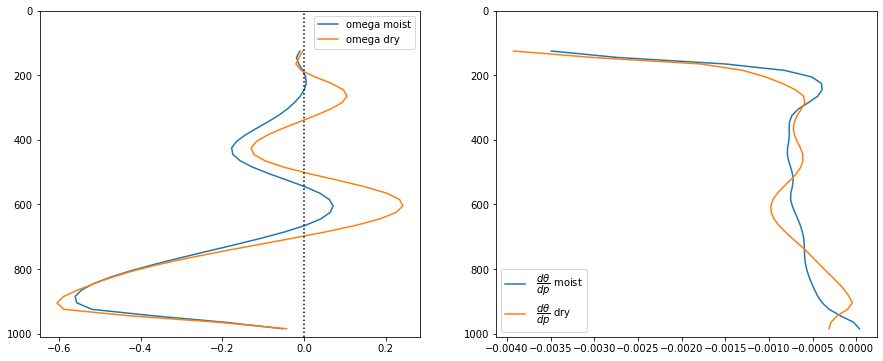

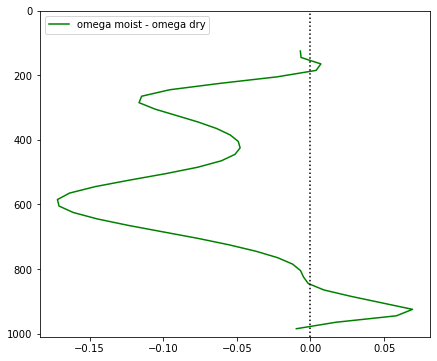

In [14]:
a1 =  1635+50//3
a2 =  1635+130//3
omega_dry = -9.81*meanRHO*meandestag_W
omega_moist = -9.81*meanRHO_m*meandestag_W_m

_,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(omega_moist.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist')
ax[0].plot(omega_dry.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_dry.pressure,label='omega dry')


ax[1].plot(meandThetadp_m.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp_m.pressure,label=r" $ \dfrac{d\theta}{dp} $ moist")
ax[1].plot(meandThetadp.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp.pressure,label=r" $ \dfrac{d\theta}{dp} $ dry")

ax[0].axvline(0.,color='k',linestyle=':')

ax[0].legend();ax[0].set_ylim(1010,0)
ax[1].legend();ax[1].set_ylim(1010,0)

_,ax=plt.subplots(1,1,figsize=(7,6))
ax.plot((omega_moist-omega_dry).sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist - omega dry',color='g')
ax.legend();ax.set_ylim(1010,0)
ax.axvline(0.,color='k',linestyle=':')

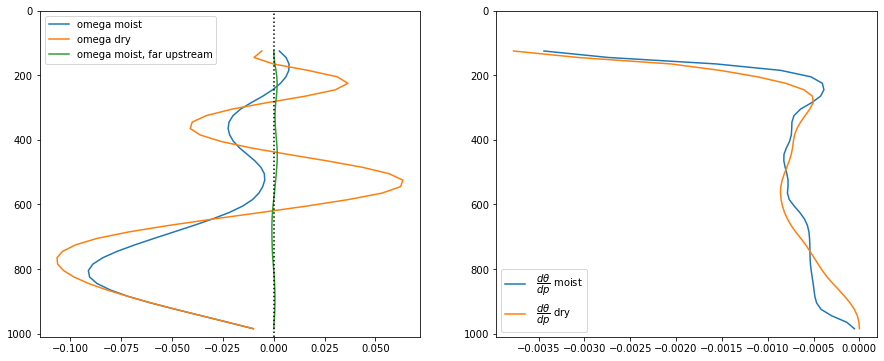

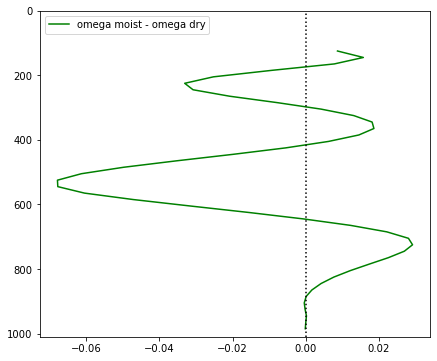

In [47]:
a1 =  1635+150//3
a2 =  1635+250//3
omega_dry = -9.81*meanRHO*meandestag_W
omega_moist = -9.81*meanRHO_m*meandestag_W_m

_,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(omega_moist.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist')
ax[0].plot(omega_dry.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_dry.pressure,label='omega dry')
ax[0].plot(omega_moist.sel(west_east=slice(2700,3270)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist, far upstream')


ax[1].plot(meandThetadp_m.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp_m.pressure,label=r" $ \dfrac{d\theta}{dp} $ moist")
ax[1].plot(meandThetadp.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp.pressure,label=r" $ \dfrac{d\theta}{dp} $ dry")

ax[0].axvline(0.,color='k',linestyle=':')

ax[0].legend();ax[0].set_ylim(1010,0)
ax[1].legend();ax[1].set_ylim(1010,0)

_,ax=plt.subplots(1,1,figsize=(7,6))
ax.plot((omega_moist-omega_dry).sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist - omega dry',color='g')
ax.legend();ax.set_ylim(1010,0)
ax.axvline(0.,color='k',linestyle=':')

(1010.0, 0.0)

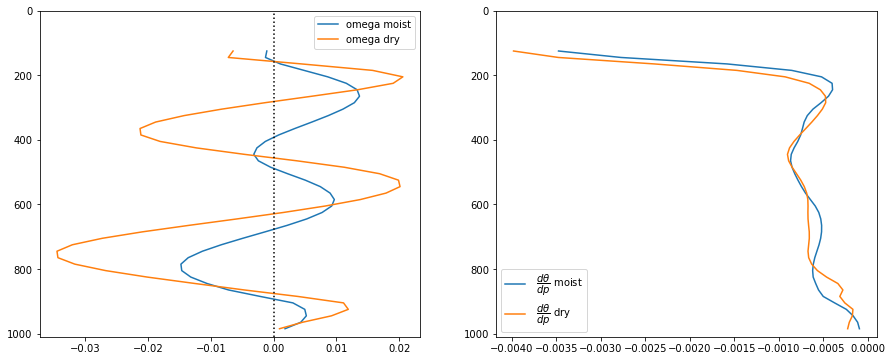

In [56]:
a1 =  1600
a2 =  1675
omega_dry   = meandestag_W  #-9.81*meanRHO*meandestag_W
omega_moist = meandestag_W_m#-9.81*meanRHO_m*meandestag_W_m

_,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(omega_moist.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_moist.pressure,label='omega moist')
ax[0].plot(omega_dry.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),omega_dry.pressure,label='omega dry')


ax[1].plot(meandThetadp_m.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp_m.pressure,label=r" $ \dfrac{d\theta}{dp} $ moist")
ax[1].plot(meandThetadp.sel(west_east=slice(a1,a2)).mean(['south_north','west_east']),meandThetadp.pressure,label=r" $ \dfrac{d\theta}{dp} $ dry")

ax[0].axvline(0.,color='k',linestyle=':')

ax[0].legend();ax[0].set_ylim(1010,0)
ax[1].legend();ax[1].set_ylim(1010,0)

In [26]:
a1 =  1600
a2 =  1675
wdrytest   = select_time(dryhrchannel.W).sel(west_east=slice(a1,a2)).mean(['south_north','west_east','Time']).persist()
wmoisttest =    select_time(hrchannel.W).sel(west_east=slice(a1,a2)).mean(['south_north','west_east','Time']).persist()

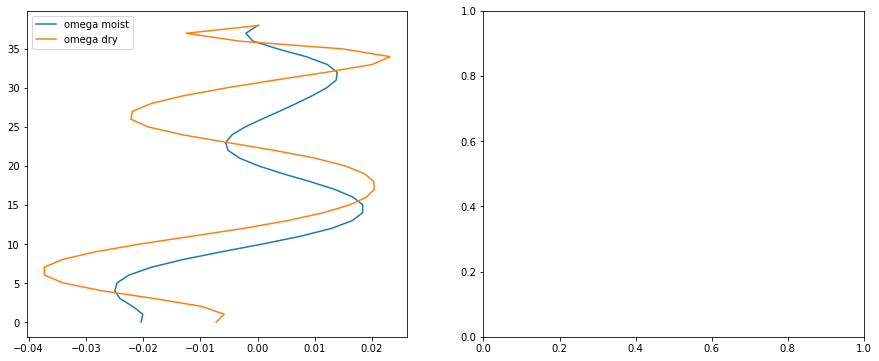

In [27]:

_,ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(wmoisttest,range(len(wdrytest  )),label='omega moist')
ax[0].plot(wdrytest  ,range(len(wmoisttest)),label='omega dry')

ax[0].legend()

## wdry dq/dp

In [37]:
hrchannelprecip=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.precip.days0-200.nc')

In [44]:
%%time
# Adiabatic term
meandqdp_m = interp_pressure(select_time(hrchannel.QVAPOR).mean('Time')).differentiate('pressure')/100.
meandq0dp_m = interp_pressure(select_time(hrchannel.QVAPOR).mean('Time')).isel(west_east=slice(2500,2600)).mean(['south_north','west_east']).differentiate('pressure')/100.

meanomegadqdp  = (-9.81*meanRHO*meandestag_W*meandqdp_m*2.26e6/1004.*86400).persist() #in K/day
meanomegadq0dp = (-9.81*meanRHO*meandestag_W*meandq0dp_m*2.26e6/1004.*86400).persist() #in K/day

CPU times: user 13.2 s, sys: 10.9 s, total: 24.2 s
Wall time: 16.4 s


In [52]:
meanomegadqdphat=dsmean4(meanomegadqdp ).load()
meanomegadq0dphat=-meanomegadq0dp.sel(west_east=slice(1500,2000)).fillna(0.).integrate('pressure').mean('south_north')/np.abs(meanomegadq0dp.pressure[0]-meanomegadq0dp.pressure[-1]).load()



In [58]:
%%time
# Advective term
meandqdx = interp_pressure(select_time(dryhrchannel.QVAPOR).mean('Time')).differentiate('west_east')/3000   # in K/meter
meandqdy = interp_pressure(select_time(dryhrchannel.QVAPOR).mean('Time')).differentiate('south_north')/3000 # in K/meter
meanugradq = ((meandestag_U*meandqdx+meandestag_V*meandqdy)*2.26e6/1004.*86400).persist() #in K/day
meanugradqhat=dsmean4(meanugradq ).load()


CPU times: user 13.8 s, sys: 11.3 s, total: 25.1 s
Wall time: 18.6 s


<xarray.DataArray (west_east: 500)>
array([            nan,             nan,             nan,             nan,
       -1.86021775e-01, -1.60481931e-01, -1.39431221e-01, -1.22000325e-01,
       -1.05148781e-01, -8.52269660e-02, -5.96418817e-02, -2.91994596e-02,
        2.13087601e-03,  3.11527731e-02,  5.68447426e-02,  7.94083740e-02,
        1.01570189e-01,  1.27795251e-01,  1.59998895e-01,  1.95751965e-01,
        2.29382929e-01,  2.55313477e-01,  2.73190665e-01,  2.88203214e-01,
        3.05898289e-01,  3.28093083e-01,  3.53797424e-01,  3.82633808e-01,
        4.12403292e-01,  4.38340016e-01,  4.58427394e-01,  4.74841982e-01,
        4.93584617e-01,  5.18560296e-01,  5.48539308e-01,  5.81587806e-01,
        6.12365462e-01,  6.30266036e-01,  6.31798592e-01,  6.26403295e-01,
        6.26636930e-01,  6.36836050e-01,  6.51703837e-01,  6.68657628e-01,
        6.86833653e-01,  6.97618556e-01,  6.99519881e-01,  7.04674289e-01,
        7.16341366e-01,  7.25329023e-01,  7.33945581e-01,  7.52869561e-01,
        7.75626055e-01,  7.88718371e-01,  7.99957008e-01,  8.16659306e-01,
        8.13670757e-01,  7.85049268e-01,  7.71458410e-01,  7.89791300e-01,
        8.18298216e-01,  8.61990671e-01,  9.30154920e-01,  9.82697604e-01,
        9.88794860e-01,  9.83853383e-01,  1.00714829e+00,  1.03962790e+00,
        1.06009068e+00,  1.08591584e+00,  1.10716485e+00,  1.09784602e+00,
        1.09306996e+00,  1.13376219e+00,  1.20658977e+00,  1.28756994e+00,
        1.35455251e+00,  1.38900203e+00,  1.41168822e+00,  1.44990968e+00,
...
        8.99065928e-02,  9.07323397e-02,  9.03437569e-02,  8.85473663e-02,
        8.60637869e-02,  8.49309699e-02,  8.65683076e-02,  9.06544149e-02,
        9.56796621e-02,  9.92330880e-02,  9.97156399e-02,  9.77861282e-02,
        9.50443837e-02,  9.26508656e-02,  9.10436933e-02,  9.00267847e-02,
        8.92701952e-02,  8.85141444e-02,  8.76336085e-02,  8.71303637e-02,
        8.78013935e-02,  8.95327199e-02,  9.10934975e-02,  9.11414576e-02,
        8.92383763e-02,  8.63976520e-02,  8.39464709e-02,  8.21592109e-02,
        8.08882720e-02,  8.00157895e-02,  7.90492899e-02,  7.75886259e-02,
        7.59056235e-02,  7.46237125e-02,  7.42608528e-02,  7.45108429e-02,
        7.45662134e-02,  7.44393631e-02,  7.46309162e-02,  7.51729827e-02,
        7.57112082e-02,  7.55399570e-02,  7.37670872e-02,  7.02194631e-02,
        6.54655651e-02,  6.05108031e-02,  5.67963515e-02,  5.53831219e-02,
        5.59411442e-02,  5.74890199e-02,  5.90387626e-02,  5.97899931e-02,
        6.00873961e-02,  6.04853728e-02,  6.03698679e-02,  5.96122854e-02,
        5.90980342e-02,  5.85139952e-02,  5.72194371e-02,  5.61697736e-02,
        5.62081345e-02,  5.74075920e-02,  6.07083825e-02,  6.58681928e-02,
        7.01066319e-02,  7.20588047e-02,  7.27201339e-02,  7.22373037e-02,
        7.10217432e-02,  7.17302117e-02,  7.56978916e-02,  8.06599823e-02,
        8.38727172e-02,  8.51407206e-02,  8.55524920e-02,  8.52811250e-02,
        8.46331085e-02,  8.48888463e-02,  8.61336280e-02,  8.69096098e-02])
Dimensions without coordinates: west_east

(-40.0, 40.0)

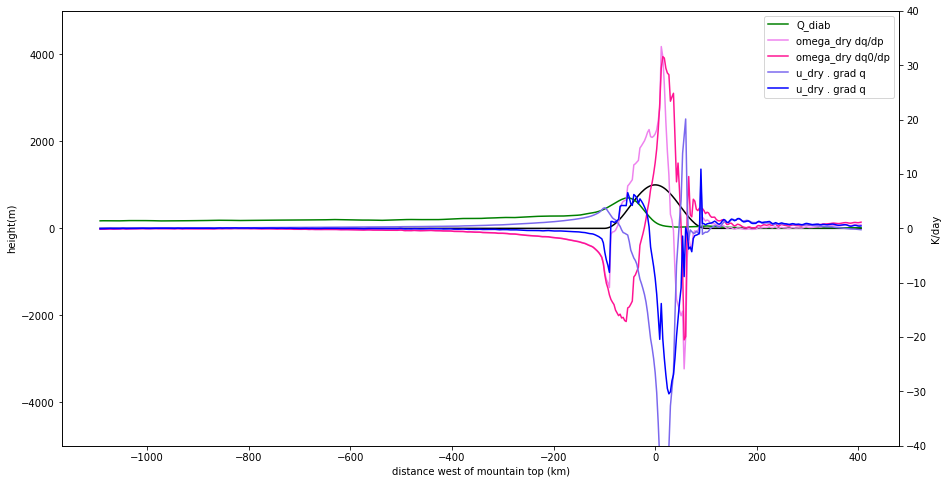

In [141]:
dist=(135-advec_dry.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist,hrhgt[1500:2000],color='k')
ax2=ax.twinx()
ax2.set_ylabel("K/day")

ax2.plot(dist, hrchannelprecip[200:,:,1500:2000].mean(["Time","south_north"])/(1004/2.26e6*77500/9.81) ,label="Q_diab",color="green")
ax2.plot(dist, meanomegadqdphat ,label="omega_dry dq/dp",color="violet")
ax2.plot(dist, meanomegadq0dphat ,label="omega_dry dq0/dp",color="deeppink")
ax2.plot(dist, despike(meanugradqhat,16.) ,label="u_dry . grad q",color="mediumslateblue")
ax2.plot(dist, despike(meanugradqhat,16.)+meanomegadqdphat ,label="u_dry . grad q",color="blue")
ax2.legend()
ax2.set_ylim(-40,40)

In [133]:
def despike(yi, th=1.):
    '''Remove spikes from an input array yi, spike being defined as a difference with the previous point of more than th. Assumes spike width is always 1'''
    y = np.copy(yi) # use y = y1 if it is OK to modify input array
    for i in range(1,len(y)-1):
        if np.abs(y[i]-y[i-1])>th :#and np.abs(y[i-1]+y[i+1]-2*y[i])>3*th:
            y[i] = (y[i-1]+y[i+1])/2
        #th = 10*np.abs(y[i-1]-y[i])
    return y

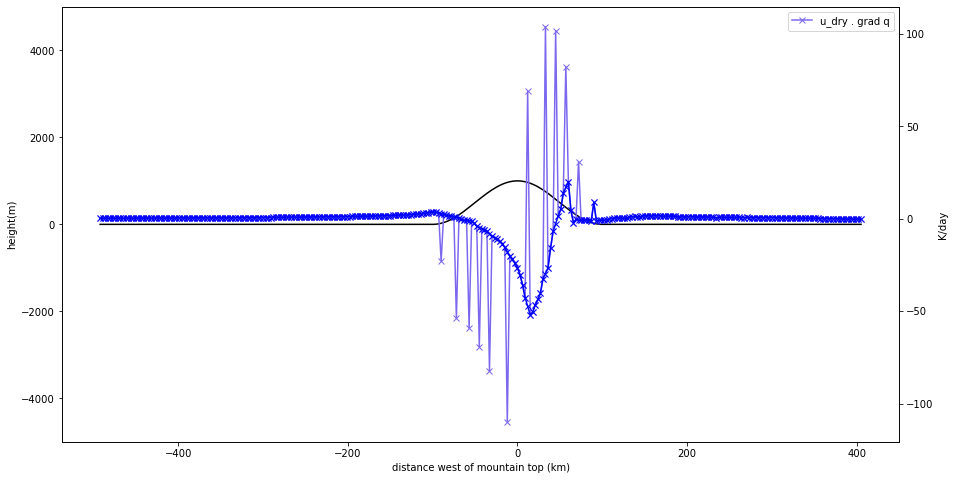

In [139]:
dist=(135-advec_dry.west_east)*3

fig, ax = plt.subplots(1,1,figsize=(15,8))
ax.set_xlabel("distance west of mountain top (km)")
ax.set_ylabel("height(m)")
ax.set_ylim(-5000,5000)
ax.plot(dist[:-200],hrhgt[1500:2000][:-200],color='k')
ax2=ax.twinx()
ax2.set_ylabel("K/day")
ax2.plot(dist[:-200], meanugradqhat[:-200] ,label="u_dry . grad q",color="mediumslateblue",marker='x')#.rolling({'west_east':10}).mean()
ax2.plot(dist[:-200], despike(meanugradqhat[:-200],16.) ,color='b',marker='x')#.rolling({'west_east':10}).mean()
ax2.legend()

In [80]:
meanugradqhat[:-200]

<xarray.DataArray (west_east: 300)>
array([-2.48612769e-01, -2.18678953e-01, -1.83021034e-01, -1.50353350e-01,
       -1.29442768e-01, -1.20913548e-01, -1.13425405e-01, -9.58665552e-02,
       -6.60956302e-02, -2.98336921e-02,  7.01187343e-03,  3.87867060e-02,
        6.07851229e-02,  7.90138554e-02,  9.86261552e-02,  1.19830031e-01,
        1.49595780e-01,  1.91910435e-01,  2.40032073e-01,  2.77391504e-01,
        2.87984855e-01,  2.79248517e-01,  2.81296378e-01,  3.15094818e-01,
        3.65866878e-01,  3.98958822e-01,  4.07770223e-01,  4.25478299e-01,
        4.63942237e-01,  4.95550500e-01,  4.99395712e-01,  4.89843162e-01,
        5.19191476e-01,  5.88820628e-01,  6.45445564e-01,  6.64638197e-01,
        6.43731444e-01,  6.08694346e-01,  5.96483405e-01,  6.18469080e-01,
        6.65806374e-01,  6.94727045e-01,  6.83033281e-01,  6.81252358e-01,
        7.09349204e-01,  7.19730890e-01,  7.04233672e-01,  7.08805321e-01,
        7.39587744e-01,  7.54287490e-01,  7.62813681e-01,  7.98853568e-01,
        8.22587791e-01,  8.05049327e-01,  8.10480675e-01,  8.46325168e-01,
        7.83910825e-01,  6.79480347e-01,  7.37095035e-01,  9.02145126e-01,
        9.88859749e-01,  1.00237310e+00,  1.02030160e+00,  9.99808453e-01,
        9.32631407e-01,  9.64152362e-01,  1.11884762e+00,  1.18269965e+00,
        1.10212234e+00,  1.06175722e+00,  1.07039743e+00,  1.07225348e+00,
        1.15881934e+00,  1.30558349e+00,  1.42589510e+00,  1.47529829e+00,
        1.40716635e+00,  1.33106691e+00,  1.41901447e+00,  1.61700236e+00,
...
        8.90755275e-01,  8.72091752e-01,  8.53872865e-01,  8.37716136e-01,
        8.25707819e-01,  8.13042930e-01,  7.92853309e-01,  7.67817591e-01,
        7.46426311e-01,  7.35260673e-01,  7.30944492e-01,  7.21086178e-01,
        7.03094830e-01,  6.85507680e-01,  6.71387847e-01,  6.56978134e-01,
        6.42850896e-01,  6.36210857e-01,  6.37081323e-01,  6.34464377e-01,
        6.22047170e-01,  6.07432140e-01,  5.98766783e-01,  5.90952235e-01,
        5.78965590e-01,  5.65678488e-01,  5.53191496e-01,  5.44346957e-01,
        5.40811221e-01,  5.36439947e-01,  5.27078126e-01,  5.17684634e-01,
        5.10217587e-01,  5.01754798e-01,  4.92562349e-01,  4.82162289e-01,
        4.71166974e-01,  4.65477691e-01,  4.66236659e-01,  4.66419122e-01,
        4.59709709e-01,  4.44981295e-01,  4.28578826e-01,  4.18635488e-01,
        4.14408897e-01,  4.10295772e-01,  4.05093801e-01,  4.01936486e-01,
        3.99398710e-01,  3.92251799e-01,  3.82544022e-01,  3.74493001e-01,
        3.67314132e-01,  3.62609144e-01,  3.62176684e-01,  3.60510778e-01,
        3.54772618e-01,  3.49458373e-01,  3.47313200e-01,  3.48600858e-01,
        3.50185088e-01,  3.46727755e-01,  3.38787967e-01,  3.31670330e-01,
        3.28375931e-01,  3.26198030e-01,  3.20895482e-01,  3.16112910e-01,
        3.18066785e-01,  3.23887452e-01,  3.27219433e-01,  3.26649584e-01,
        3.22193167e-01,  3.14350538e-01,  3.08777270e-01,  3.09625227e-01,
        3.11772532e-01,  3.08792178e-01,  3.05050816e-01,  3.08444040e-01])
Dimensions without coordinates: west_east

# Vertical profiles of W/Omega

In [152]:
%%time
meandestag_W_m = interp_pressure(wrf.destagger(select_time(hrchannel.W).mean('Time'),0,meta=True))
meanRHO_m = interp_pressure(select_time(hrchannel.RHO).mean('Time'))
meandestag_W = interp_pressure(wrf.destagger(select_time(dryhrchannel.W).mean('Time'),0,meta=True))
meanRHO = interp_pressure(select_time(dryhrchannel.RHO).mean('Time'))


CPU times: user 29.1 s, sys: 2min 15s, total: 2min 44s
Wall time: 2min 15s


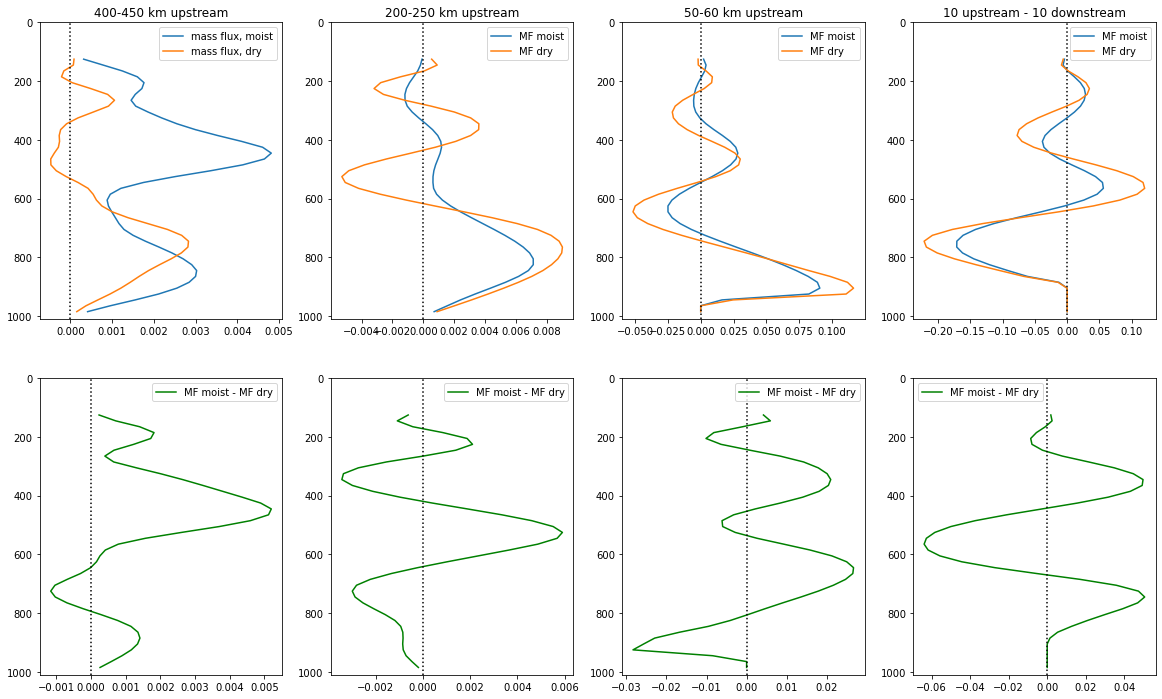

In [155]:
def f(x):
    """convert km upstream to model longitude"""
    return 1635+x//3

MF_m = meanRHO_m*meandestag_W_m
MF_d = meanRHO*meandestag_W

_,ax=plt.subplots(2,4,figsize=(20,12))

ax[0,0].set_title("400-450 km upstream")
ax[0,0].plot(MF_m.sel(west_east=slice(f(400),f(450))).mean(['south_north','west_east']),omega_moist.pressure,label='mass flux, moist')
ax[0,0].plot(MF_d.sel(west_east=slice(f(400),f(450))).mean(['south_north','west_east']),omega_dry.pressure  ,label='mass flux, dry')

ax[0,1].set_title("200-250 km upstream" )
ax[0,1].plot(MF_m.sel(west_east=slice(f(200),f(250))).mean(['south_north','west_east']),omega_moist.pressure,label='MF moist')
ax[0,1].plot(MF_d.sel(west_east=slice(f(200),f(250))).mean(['south_north','west_east']),omega_dry.pressure  ,label='MF dry')

ax[0,2].set_title("50-60 km upstream" )
ax[0,2].plot(MF_m.sel(west_east=slice(f(50),f(60))).mean(['south_north','west_east']),omega_moist.pressure,label='MF moist')
ax[0,2].plot(MF_d.sel(west_east=slice(f(50),f(60))).mean(['south_north','west_east']),omega_dry.pressure  ,label='MF dry')

ax[0,3].set_title("10 upstream - 10 downstream" )
ax[0,3].plot(MF_m.sel(west_east=slice(f(-10),f(10))).mean(['south_north','west_east']),omega_moist.pressure,label='MF moist')
ax[0,3].plot(MF_d.sel(west_east=slice(f(-10),f(10))).mean(['south_north','west_east']),omega_dry.pressure  ,label='MF dry')


ax[1,0].plot(MF_m.sel(west_east=slice(f(400),f(450))).mean(['south_north','west_east'])-MF_d.sel(west_east=slice(f(400),f(450))).mean(['south_north','west_east']),omega_moist.pressure,color='g',label='MF moist - MF dry')
ax[1,1].plot(MF_m.sel(west_east=slice(f(200),f(250))).mean(['south_north','west_east'])-MF_d.sel(west_east=slice(f(200),f(250))).mean(['south_north','west_east']),omega_moist.pressure,color='g',label='MF moist - MF dry')
ax[1,2].plot(MF_m.sel(west_east=slice(f(50),f(60))).mean(['south_north','west_east'])-MF_d.sel(west_east=slice(f(50),f(60))).mean(['south_north','west_east']),    omega_moist.pressure,color='g',label='MF moist - MF dry')
ax[1,3].plot(MF_m.sel(west_east=slice(f(-10),f(10))).mean(['south_north','west_east'])-MF_d.sel(west_east=slice(f(-10),f(10))).mean(['south_north','west_east']),  omega_moist.pressure,color='g',label='MF moist - MF dry')

for a in ax.reshape(-1):
    a.axvline(0.,color='k',linestyle=':')
    a.legend()
    a.set_ylim(1010,0)
    

# Standard deviation of W

In [15]:
%time wmean_resampled_hr=dryhrchannel.W.isel(Time=slice(200,400))[:,:,::4,1635-500//3:1635+500//3].coarsen(Time=4).mean()
%time wstd_resampled_hr =wmean_resampled_hr.mean('south_north').std('Time').persist()


CPU times: user 24.5 ms, sys: 0 ns, total: 24.5 ms
Wall time: 23.8 ms
CPU times: user 7.32 s, sys: 2min 12s, total: 2min 19s
Wall time: 7min 9s


In [22]:
wstd_resampled_hr.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.dry.3km/diags/wrf.W.24hstd.hr.days50-100.nc')


In [27]:
%time wmean_resampled_hr=hrchannel.W.isel(Time=slice(200,400))[:,:,::4,1635-500//3:1635+500//3].coarsen(Time=4).mean()
%time wstd_resampled_hr_m =wmean_resampled_hr.mean('south_north').std('Time').persist()

CPU times: user 26.5 ms, sys: 3.69 ms, total: 30.2 ms
Wall time: 29 ms
CPU times: user 9.05 s, sys: 21.1 s, total: 30.2 s
Wall time: 7min 1s


In [28]:
wstd_resampled_hr_m.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.W.24hstd.hr.days50-100.nc')


In [29]:
def change_coords_eta(sim,w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3,'eta_level':sim.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()
wstd_resampled_hr_plot=change_coords_eta(dryhrchannel,wstd_resampled_hr,center=500//3)
wstd_resampled_hr_m_plot=change_coords_eta(hrchannel,wstd_resampled_hr_m,center=500//3)

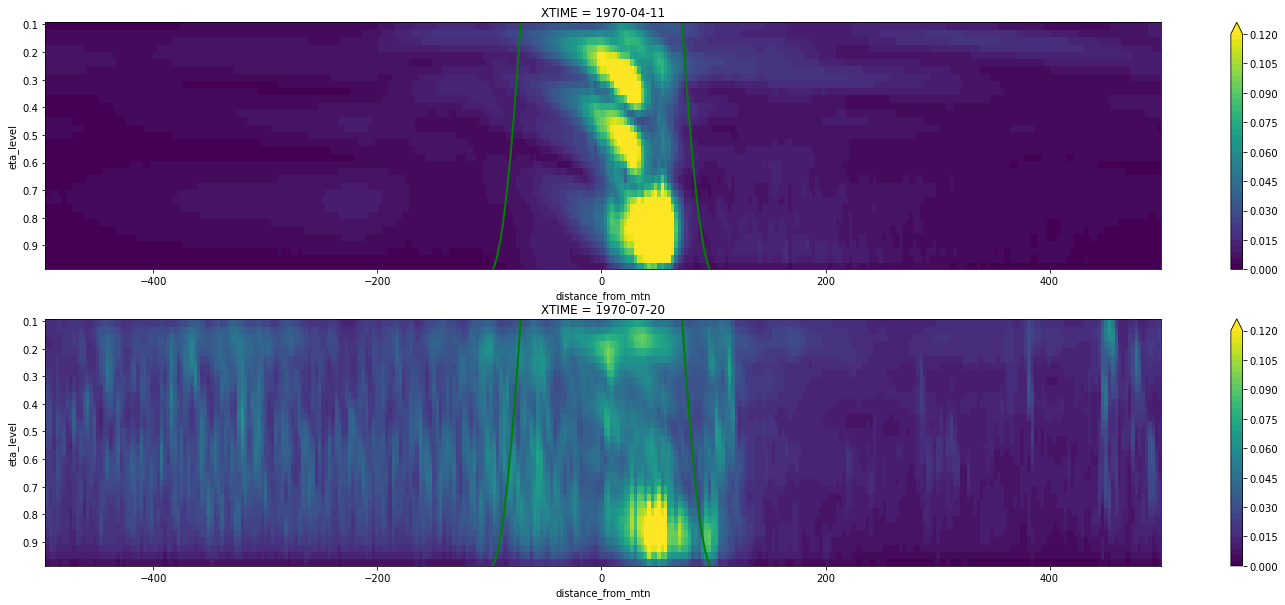

In [30]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(25,10))

ax.set_title("W daily std")
(wstd_resampled_hr_plot[1:-4]).plot(ax=ax, yincrease=False,levels=np.linspace(0,0.12,41))
ax.plot(wstd_resampled_hr_plot.distance_from_mtn, 1-hrhgt[1635-500//3:1635+500//3]/200,color='g',linewidth=2)

(wstd_resampled_hr_m_plot[1:-4]).plot(ax=ax2, yincrease=False,levels=np.linspace(0,0.12,41))
ax2.plot(wstd_resampled_hr_plot.distance_from_mtn, 1-hrhgt[1635-500//3:1635+500//3]/200,color='g',linewidth=2)

# Temperature profile

In [35]:
%%time

T_d=interp_pressure(dryhrchannel.T[250:300].mean('Time')).persist()
T_m=interp_pressure(   hrchannel.T[250:300].mean('Time')).persist()

tprof_d=T_d[:,:,1635-1500//3:1635+1500//3].mean('south_north').persist()
tprof_m=T_m[:,:,1635-1500//3:1635+1500//3].mean('south_north').persist()

tprofups_d=T_d[:,:,1635+2000//3:1635+2200//3].mean(['south_north','west_east']).persist()
tprofups_m=T_m[:,:,1635+2000//3:1635+2200//3].mean(['south_north','west_east']).persist()

CPU times: user 9.16 s, sys: 6.31 s, total: 15.5 s
Wall time: 12.6 s


In [36]:
def change_coords_sfc(w,center=1635):
    return w.assign_coords({'distance_from_mtn':(center-w.west_east)*3}).swap_dims({'west_east':'distance_from_mtn'}).persist()


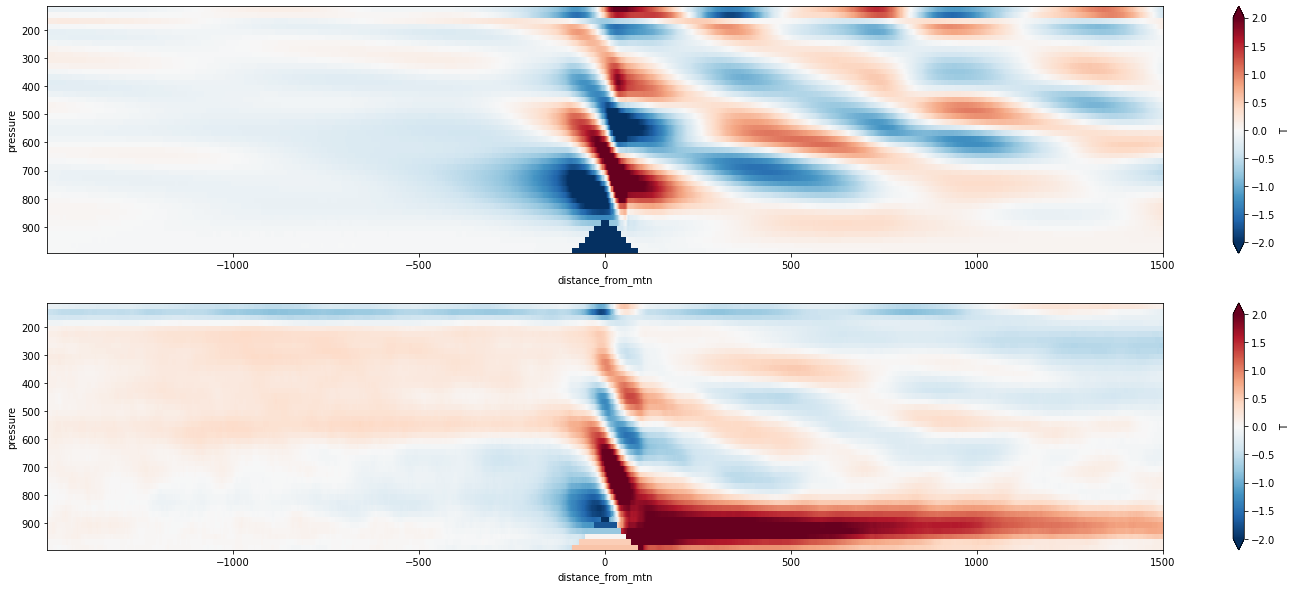

In [37]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(25,10))

change_coords_sfc(tprof_d-tprofups_d,1500//3).plot(ax=ax,  yincrease=False,vmin=-2,vmax=2,cmap=plt.cm.RdBu_r)
change_coords_sfc(tprof_m-tprofups_m,1500//3).plot(ax=ax2, yincrease=False,vmin=-2,vmax=2,cmap=plt.cm.RdBu_r)